In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0'
#EXPERIMENT = 'baseline_label_transpose_smooth05/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_NOaug_b8'
# EXPERIMENT = 'mased_scores/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number - filename
DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/'
DF_FOLDS = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
FOLD = 0

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 200

DIM = [8, 64, 64] # network input shape for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 3 # depth of the encoder
FILTERS = 64 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
REDUCE_LR_ON_PLAEAU_PATIENCE = 5
DECAY_FACTOR = 0.7 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-12 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = True
AUGMENT_PHASES_RANGE = (-3,3)
REPEAT_ONEHOT = True
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10


Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-03-01 22:29:01,731 INFO -------------------- Start --------------------
2021-03-01 22:29:01,731 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-03-01 22:29:01,731 INFO Log file: ./logs/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0.log
2021-03-01 22:29:01,732 INFO Log level for console: INFO
2021-03-01 22:29:01,733 INFO Is built with tensorflow: True
2021-03-01 22:29:01,792 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-03-01 22:29:02,488 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarn

{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29', 'MODEL_PATH': 'exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model', 'TENSORBOARD_PATH': 'exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/tensorboard_logs', 'CONFIG_PATH': 'exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/config', 'HISTORY_PATH': 'exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/history', 'DATA_PATH_SAX': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/', 'DF_FOLDS': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv', 'DF_META': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/

In [2]:
# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-03-01 22:29:02,511 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-03-01 22:29:02,518 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/
2021-03-01 22:29:02,519 INFO Patients train: 209
2021-03-01 22:29:02,530 INFO Selected 209 of 278 files with 209 of 279 patients for training fold 0
2021-03-01 22:29:02,530 INFO SAX train CMR: 209, SAX train masks: 209
2021-03-01 22:29:02,531 INFO SAX val CMR: 69, SAX val masks: 69


In [3]:
# check if we find each patient in the corresponding dataframe
import re
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]

files_ = x_train_sax + x_val_sax
info('Check if we find the patient ID and phase mapping for all: {} files.'.format(len(files_)))
for x in files_:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))
info('Done!')

2021-03-01 22:29:03,186 INFO Check if we find the patient ID and phase mapping for all: 278 files.
2021-03-01 22:29:03,454 INFO Done!


In [4]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [8]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax , config=val_config)

2021-03-01 22:32:27,771 INFO Create DataGenerator
2021-03-01 22:32:27,772 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 209 
 Augment: True 
 Thread workers: 8
2021-03-01 22:32:27,773 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-03-01 22:32:27,786 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-03-01 22:32:27,786 INFO Temporal phase augmentation: 
TrueRepeat volume: True
2021-03-01 22:32:27,787 INFO Create DataGenerator
2021-03-01 22:32:27,787 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 69 
 Augment: False 
 Thread workers: 8
2021-03-01 22:32:27,788 INFO No augmentation
2021-03-01 22:32:27,801 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-03-01 22:32:27,801 INFO Temporal phase augmentation: 
FalseRepeat volume: True


In [9]:
# visualise one batch
generator = batch_generator
@interact_manual
def select_image_in_batch(batch = (0,len(generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_overview=True,
                         show_input_vol=False):
    
    import time
    global inputs, outputs, gt_len_msk
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = generator.__getitem__(batch)
    onehot, gt_len_msk = np.split(outputs, indices_or_sections=2,axis=1)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_overview:

        show_phases(outputs)
        plt.show()
        
        selected_input = inputs[im]
        selected_output = onehot[im][0]
        selected_gt_len_msk = gt_len_msk[im][0]
        selected_gtlen = int(np.sum((selected_gt_len_msk[0]),axis=0))
        logging.info('GT length: {}'.format(selected_gtlen))
        logging.debug('pad: \n{}'.format(selected_output))
        
        """f, axs = plt.subplots(1,2,figsize=(12,4))
        i = 0
        temp_y = selected_output
        print(np.sum(temp_y, axis=1))

        # ind_gt = np.argmax(temp_y[:selected_gtlen,:], axis=0) # before we had the gt mask
        ind_gt = np.argmax(temp_y * selected_gt_len_msk, axis=1)
        axs[0].title.set_text('y')
        axs[0].set_xticks(ind_gt, minor=False)
        axs[0].set_yticks([0,1,2,3,4], minor=False)
        axs[0].set_yticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto', )
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()"""
    
    if show_input_vol:
        f, axs = plt.subplots(1,1,figsize=(4,4))
        axs.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))
        
        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))


interactive(children=(IntSlider(value=13, description='batch', max=26), IntSlider(value=3, description='im', m…

0


2021-03-01 22:32:30,945 INFO Preprocessing took: 0.882


(8, 36, 8, 64, 64, 1) (8, 2, 36, 5)
selected batch : 0


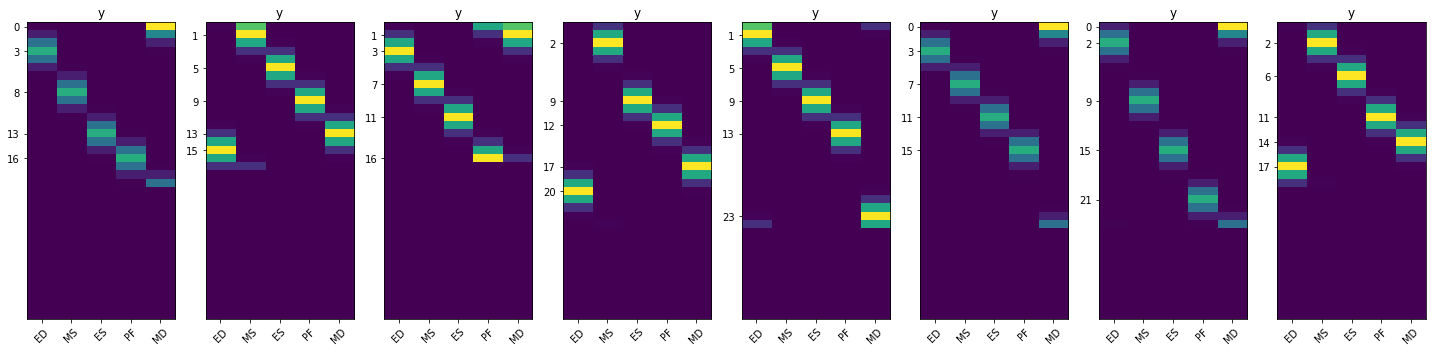

2021-03-01 22:32:31,336 INFO GT length: 5


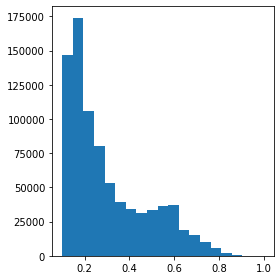

2021-03-01 22:32:32,950 INFO Preprocessing took: 0.811


(8, 36, 8, 64, 64, 1) (8, 2, 36, 5)
selected batch : 0


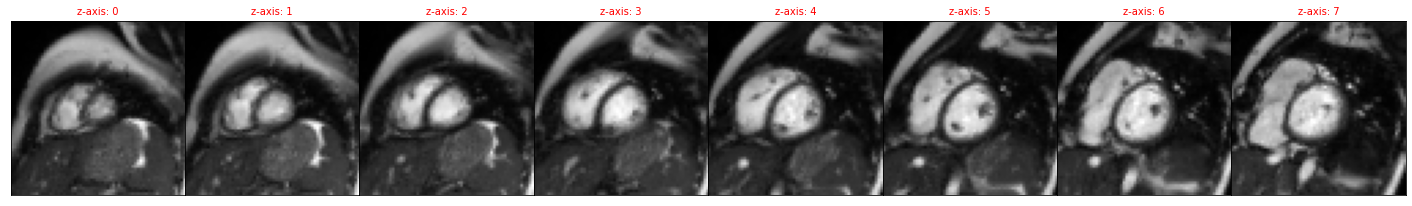

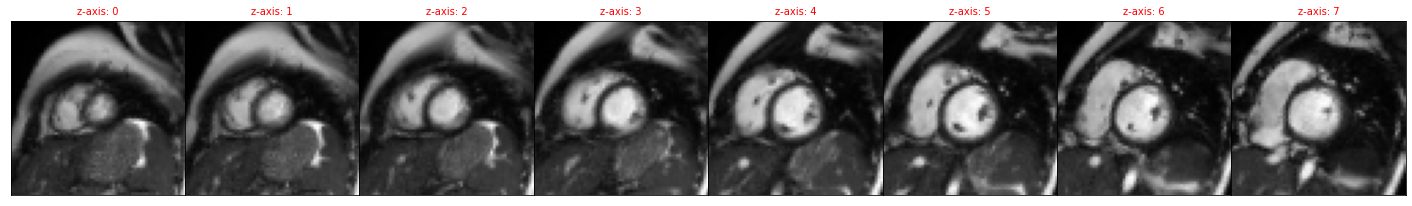

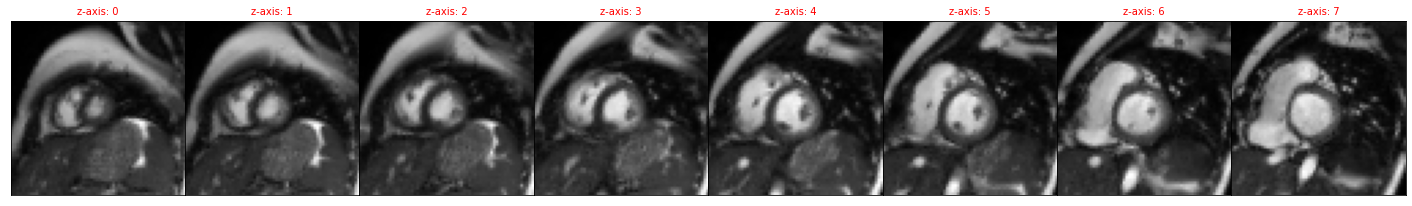

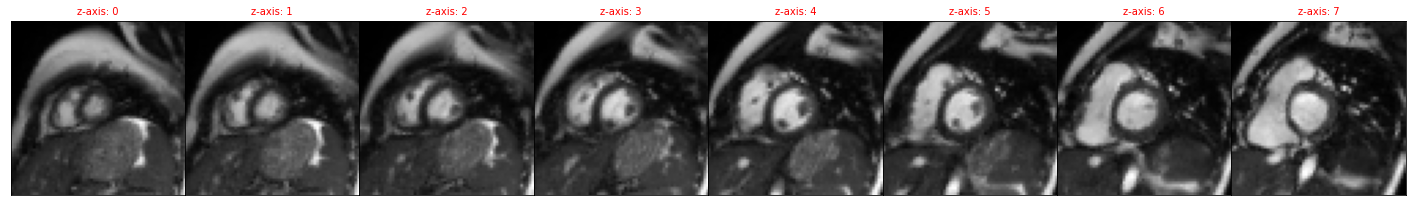

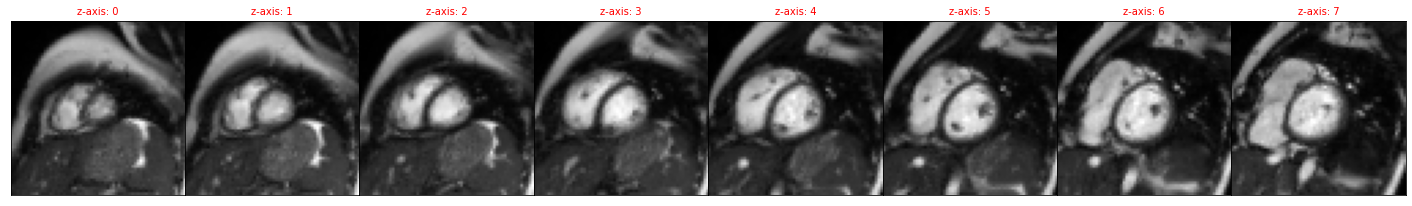

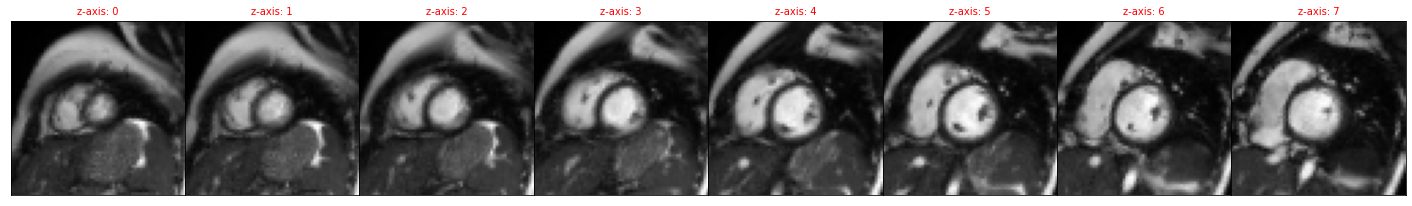

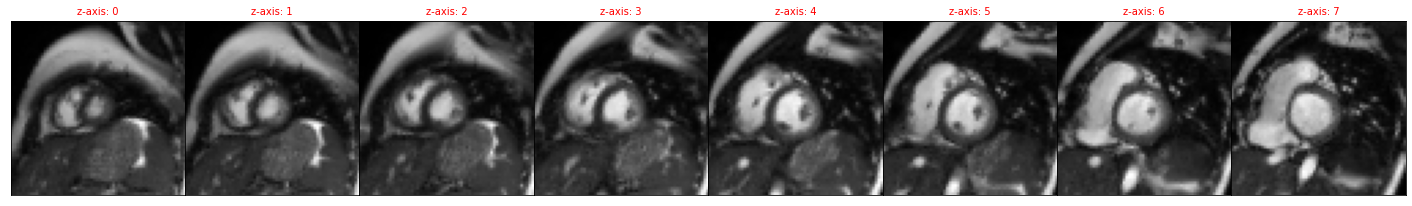

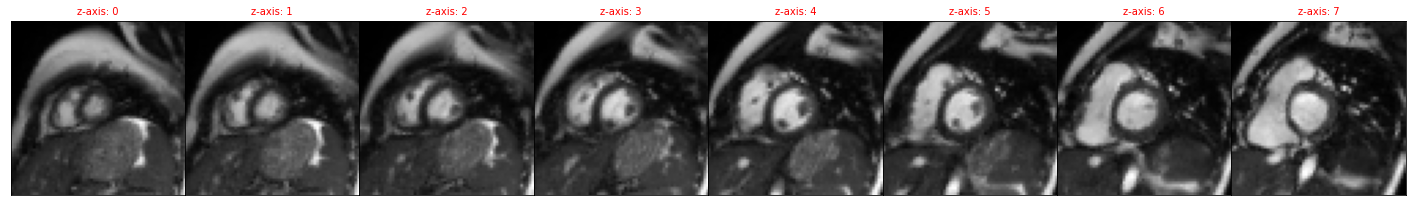

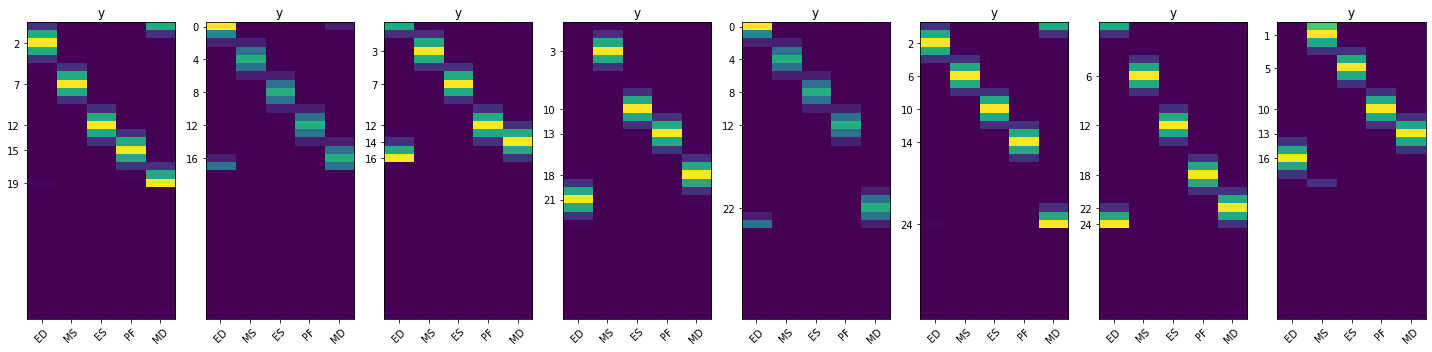

2021-03-01 22:32:34,583 INFO GT length: 5


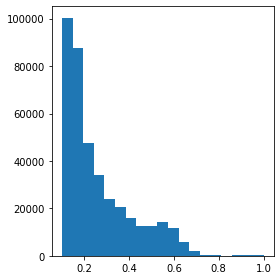

2021-03-01 22:32:36,360 INFO Preprocessing took: 0.897


(8, 36, 8, 64, 64, 1) (8, 2, 36, 5)
selected batch : 0


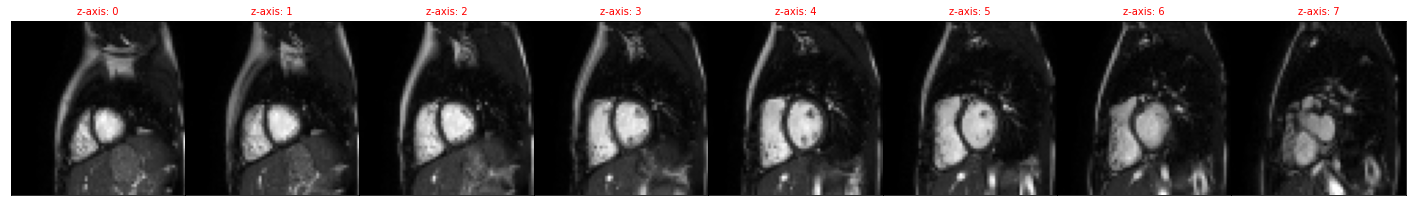

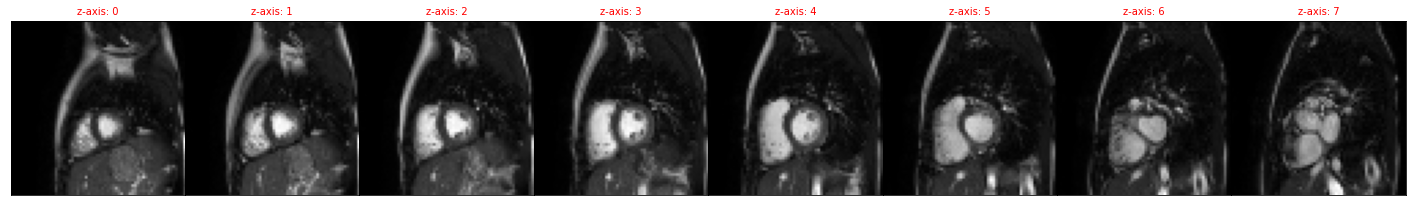

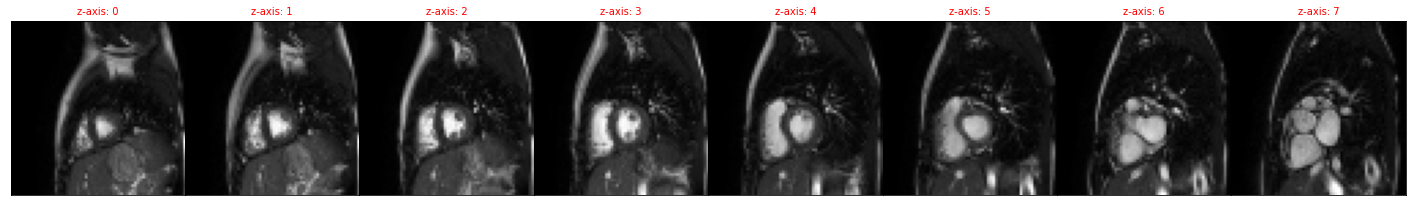

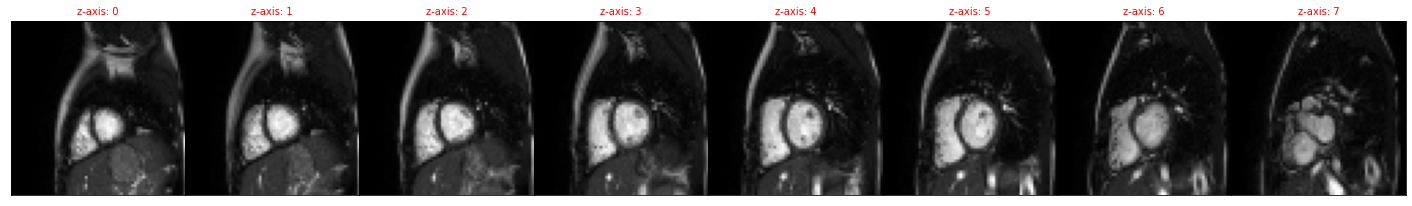

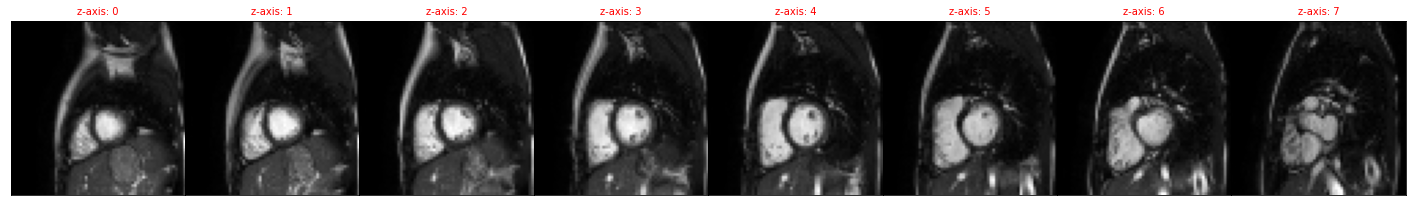

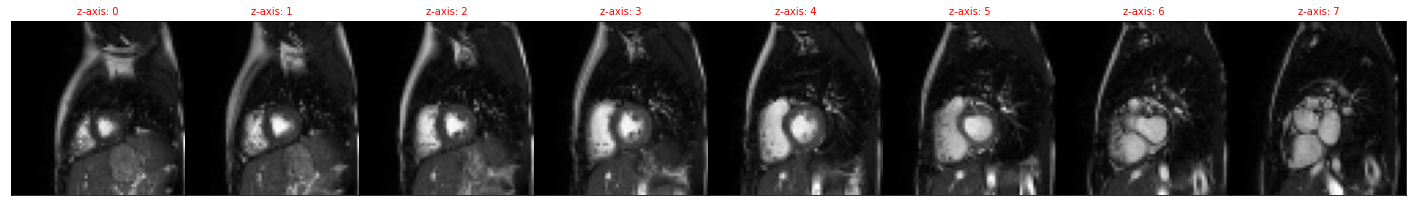

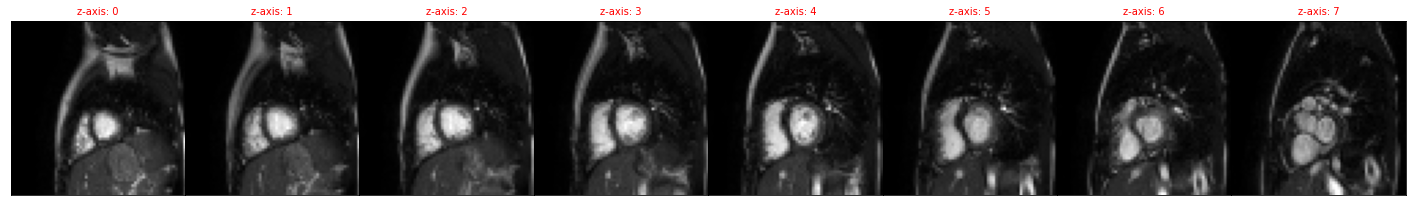

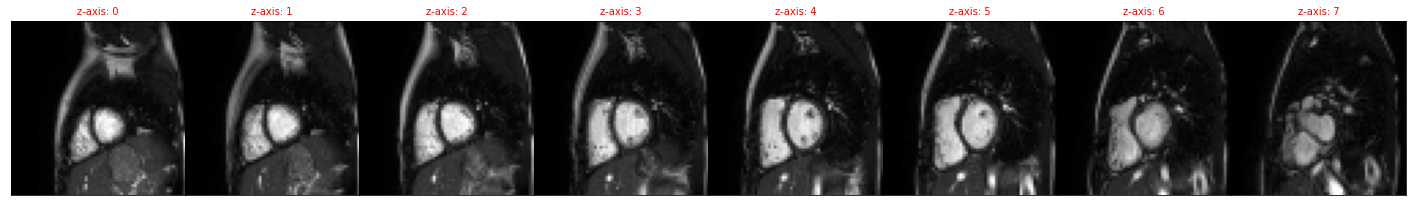

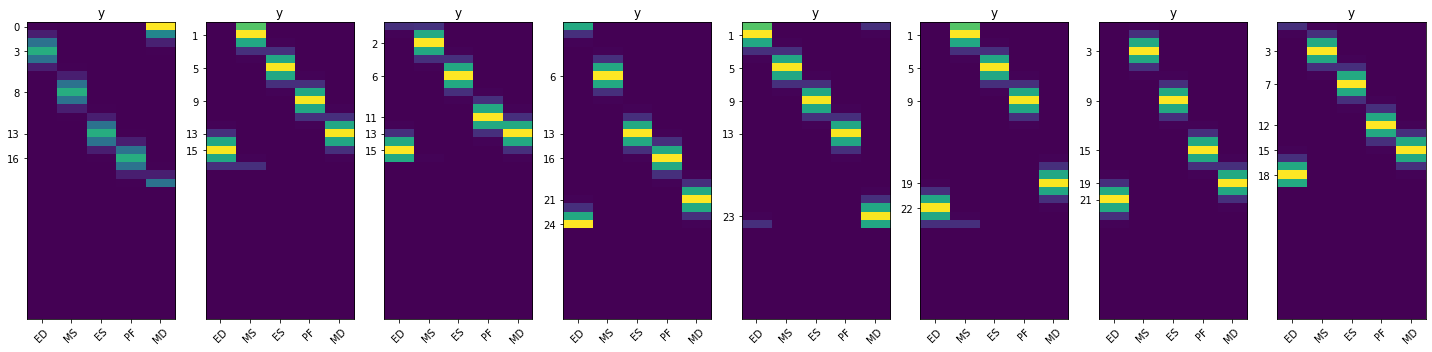

2021-03-01 22:32:37,971 INFO GT length: 5


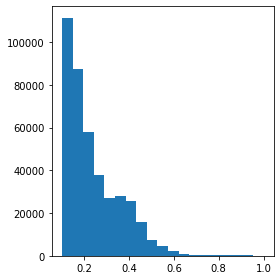

2021-03-01 22:32:39,639 INFO Preprocessing took: 0.843


(8, 36, 8, 64, 64, 1) (8, 2, 36, 5)
selected batch : 0


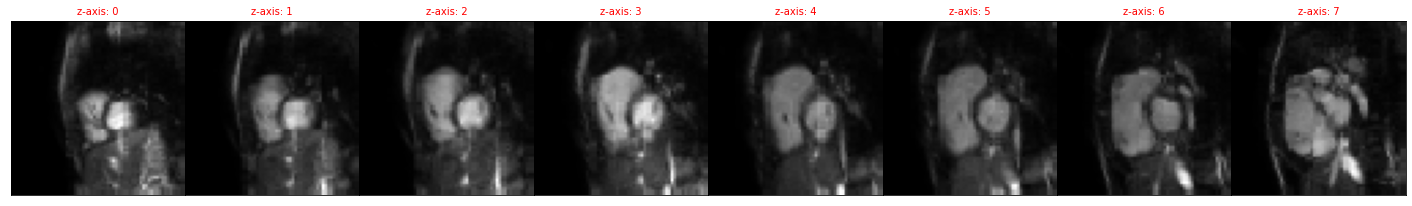

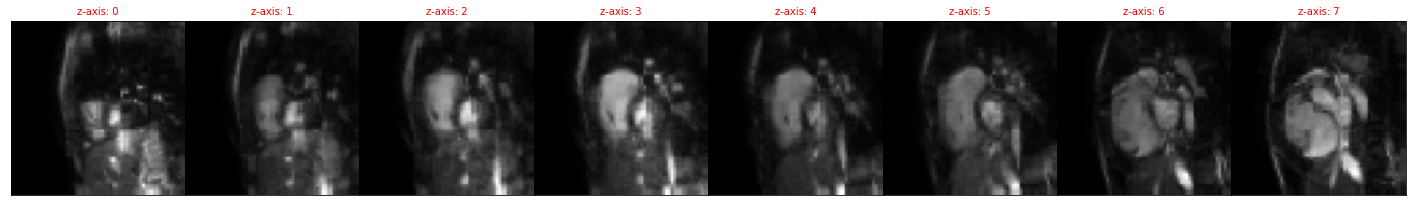

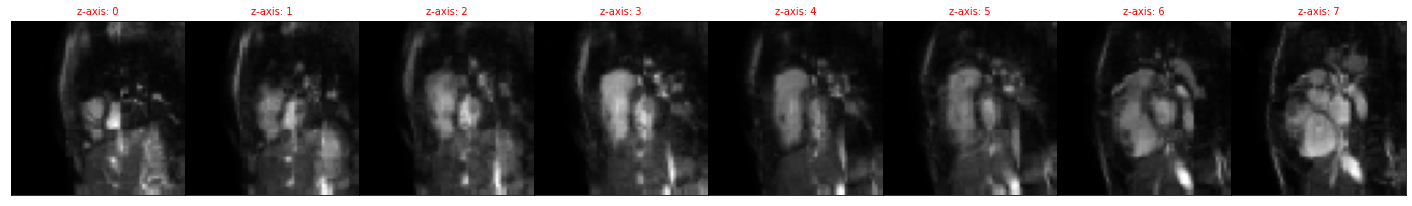

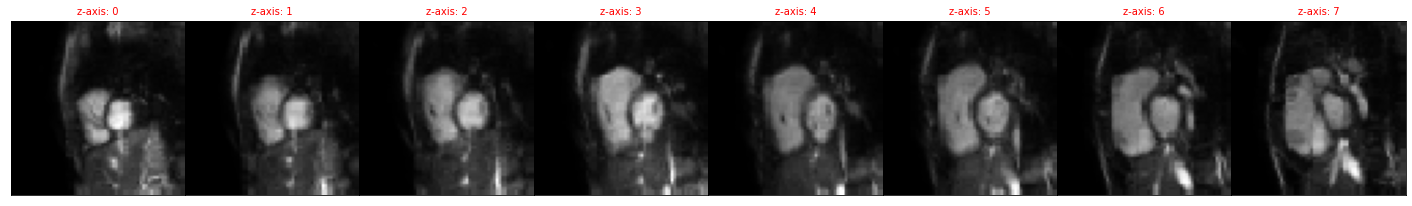

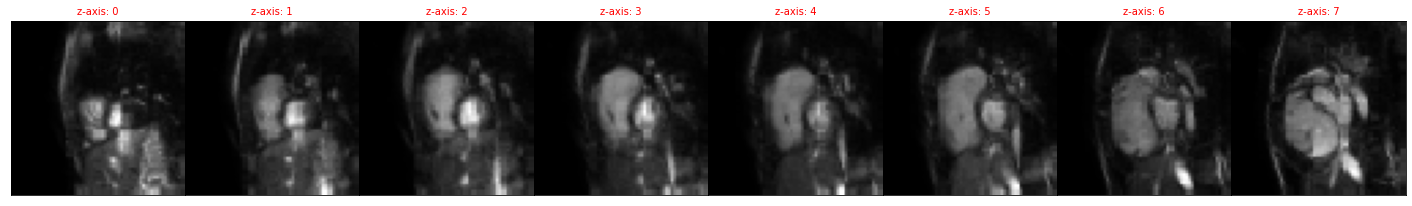

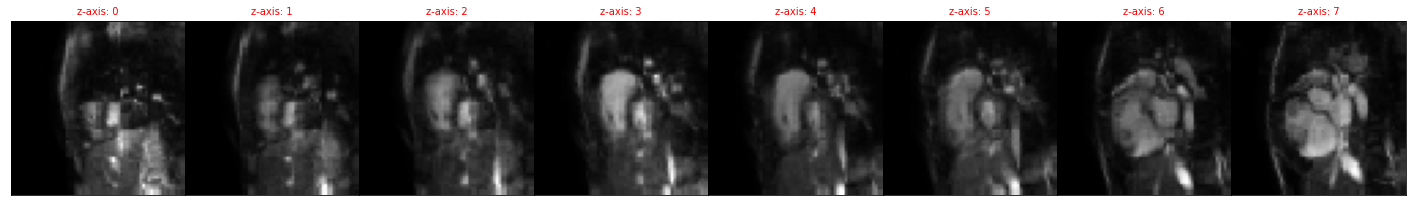

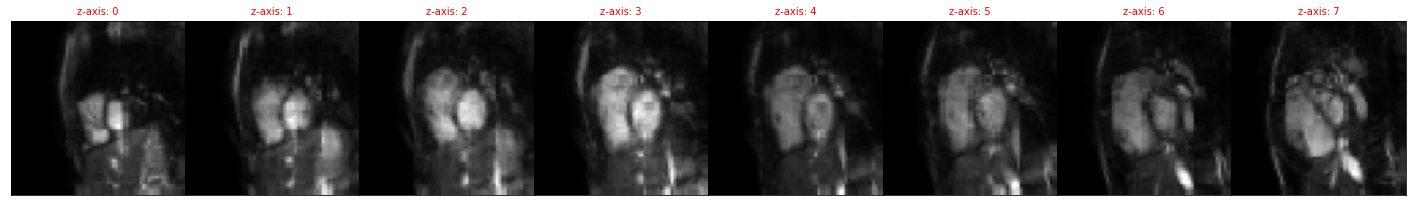

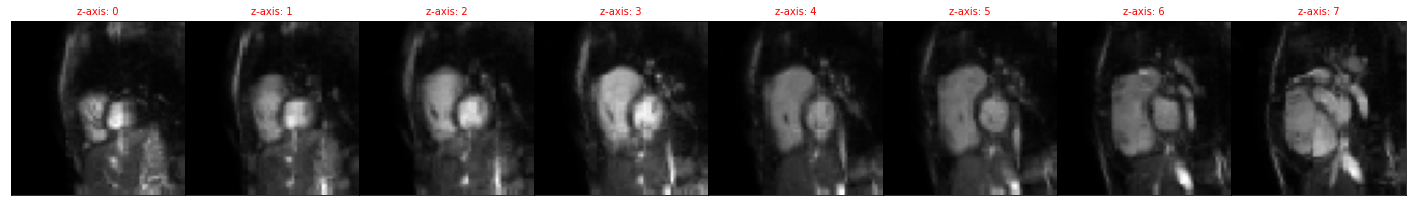

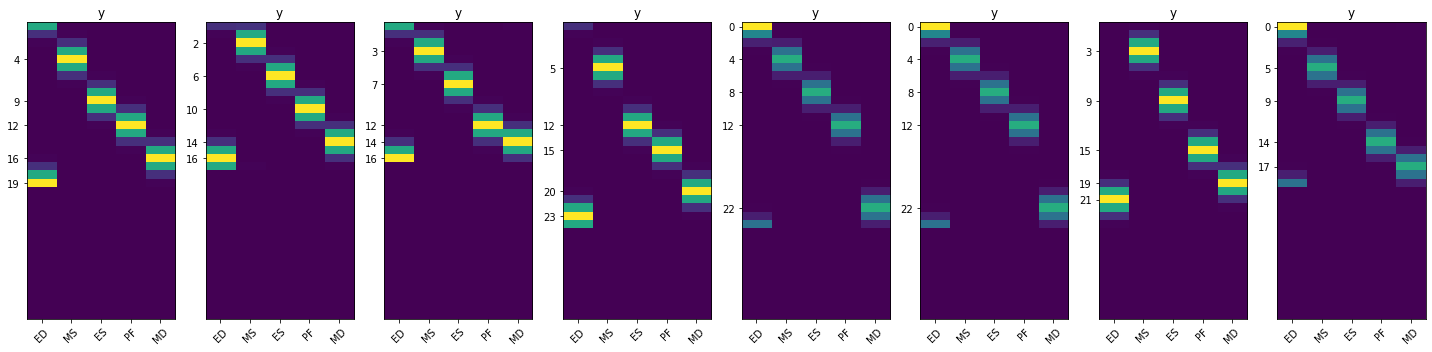

2021-03-01 22:32:41,248 INFO GT length: 5


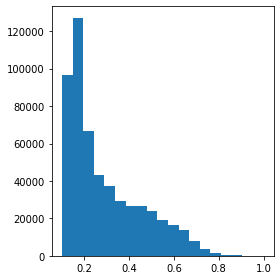

2021-03-01 22:32:42,964 INFO Preprocessing took: 0.878


(8, 36, 8, 64, 64, 1) (8, 2, 36, 5)
selected batch : 0


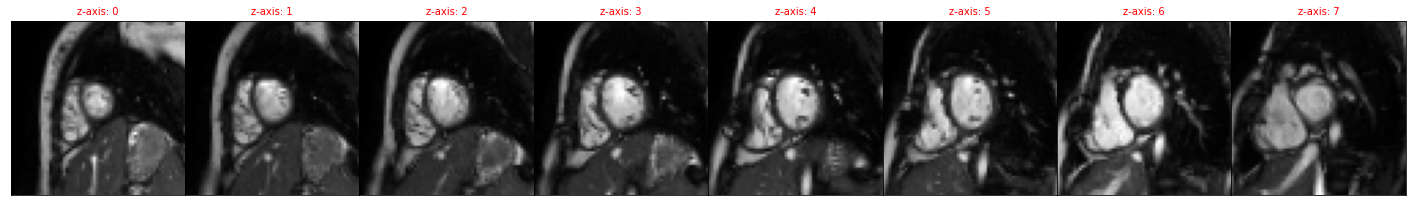

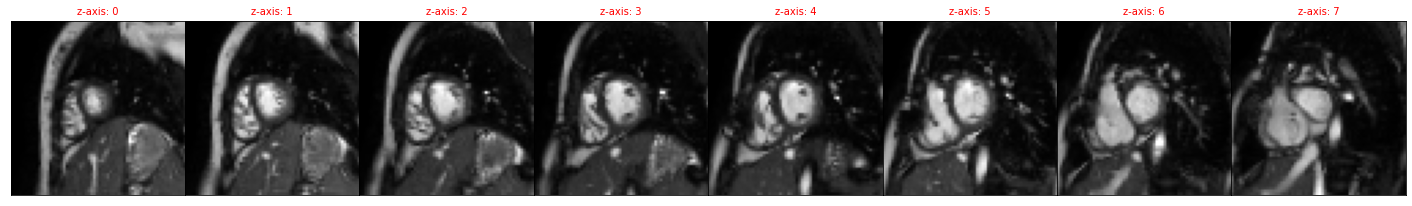

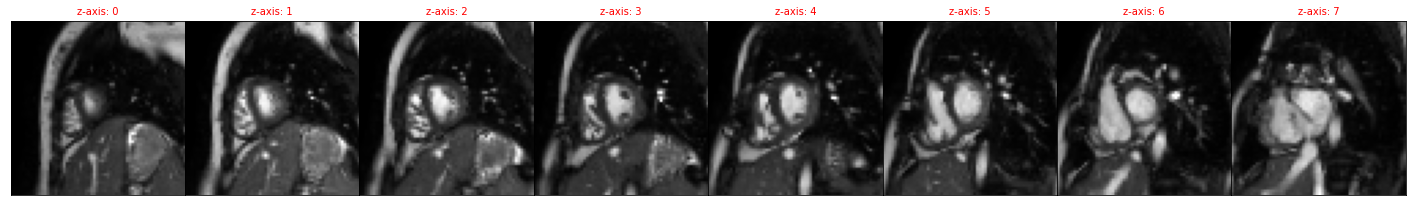

KeyboardInterrupt: 

In [10]:
# test if all batches are processable
for b in range(len(batch_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_overview=True, show_input_vol=True)

In [11]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

Shape after the temporal encoder
(None, 36, 8, 8, 8, 512)
Shape after GAP
(None, 36, 512)
Shape after Bi-LSTM layer
(None, 36, 512)
Shape after final conv layer
(None, 36, 5)


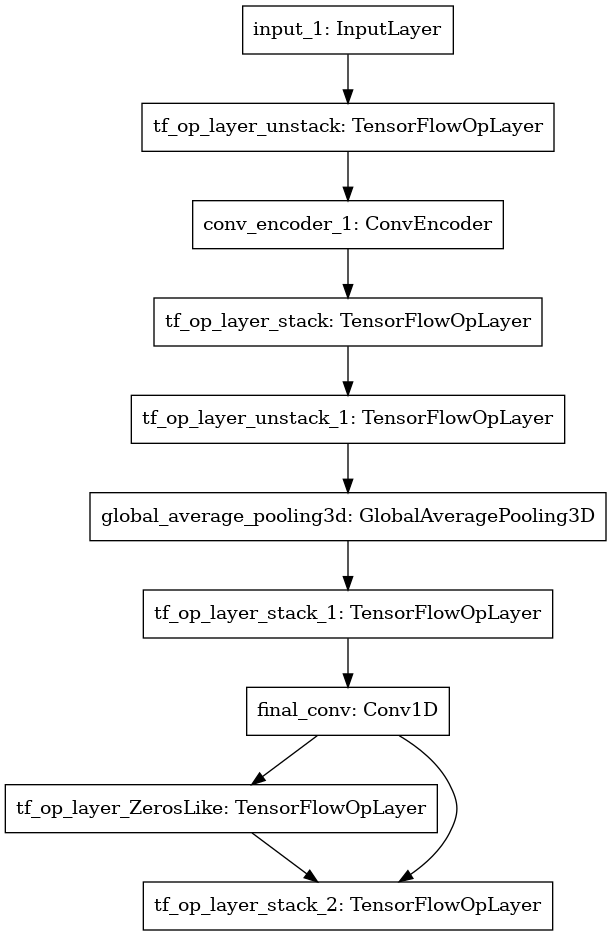

In [12]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
tf.keras.utils.plot_model(
    model, show_shapes=False,
    to_file=os.path.join(EXP_PATH, 'model.png'),
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=True, dpi=96
)
    
#model.summary(line_length=150)

In [13]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    use_multiprocessing=False,
    verbose=1)

2021-03-01 22:32:59,514 INFO feed 4 Tensorboard is ready


Epoch 1/200
26/26 [==============================] - ETA: 0s - loss: 1.1245 - mse_wrapper: 1.1245 - ca_wrapper: 0.4411 - meandiff: 15.2837

2021-03-01 22:34:33,402 INFO (4, 2, 36, 5)
2021-03-01 22:34:34,314 INFO (4, 2, 36, 5)



Epoch 00001: loss improved from inf to 1.12452, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 65s 2s/step - loss: 1.1245 - mse_wrapper: 1.1245 - ca_wrapper: 0.4411 - meandiff: 15.2837 - val_loss: 1.7021 - val_mse_wrapper: 1.7021 - val_ca_wrapper: 0.3273 - val_meandiff: 15.3281 - lr: 1.0000e-04
Epoch 2/200
26/26 [==============================] - ETA: 0s - loss: 0.9253 - mse_wrapper: 0.9253 - ca_wrapper: 0.5381 - meandiff: 9.5000

2021-03-01 22:35:38,130 INFO (4, 2, 36, 5)
2021-03-01 22:35:38,805 INFO (4, 2, 36, 5)



Epoch 00002: loss improved from 1.12452 to 0.92534, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 61s 2s/step - loss: 0.9253 - mse_wrapper: 0.9253 - ca_wrapper: 0.5381 - meandiff: 9.5000 - val_loss: 1.1313 - val_mse_wrapper: 1.1313 - val_ca_wrapper: 0.5269 - val_meandiff: 10.2812 - lr: 1.0000e-04
Epoch 3/200
26/26 [==============================] - ETA: 0s - loss: 0.7956 - mse_wrapper: 0.7956 - ca_wrapper: 0.6589 - meandiff: 7.9808

2021-03-01 22:36:45,125 INFO (4, 2, 36, 5)
2021-03-01 22:36:45,816 INFO (4, 2, 36, 5)



Epoch 00003: loss improved from 0.92534 to 0.79557, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 64s 2s/step - loss: 0.7956 - mse_wrapper: 0.7956 - ca_wrapper: 0.6589 - meandiff: 7.9808 - val_loss: 1.0036 - val_mse_wrapper: 1.0036 - val_ca_wrapper: 0.6406 - val_meandiff: 9.9688 - lr: 1.0000e-04
Epoch 4/200
26/26 [==============================] - ETA: 0s - loss: 0.7511 - mse_wrapper: 0.7511 - ca_wrapper: 0.6804 - meandiff: 7.3365

2021-03-01 22:37:56,330 INFO (4, 2, 36, 5)
2021-03-01 22:37:57,023 INFO (4, 2, 36, 5)



Epoch 00004: loss improved from 0.79557 to 0.75107, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.7511 - mse_wrapper: 0.7511 - ca_wrapper: 0.6804 - meandiff: 7.3365 - val_loss: 1.1411 - val_mse_wrapper: 1.1411 - val_ca_wrapper: 0.6727 - val_meandiff: 7.0625 - lr: 1.0000e-04
Epoch 5/200
26/26 [==============================] - ETA: 0s - loss: 0.6970 - mse_wrapper: 0.6970 - ca_wrapper: 0.7167 - meandiff: 6.8654
Epoch 00005: loss improved from 0.75107 to 0.69699, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.6970 - mse_wrapper: 0.6970 - ca_wrapper: 0.7167 - meandiff: 6.8654 - val_loss: 0.9848 - val_mse_wrapper: 0.9848 - val_ca_wrapper: 0.7062 - val_meandiff: 5.9062 - lr: 1.0000e-04
Epoch 6/200
26/26 [

2021-03-01 22:40:17,983 INFO (4, 2, 36, 5)
2021-03-01 22:40:18,662 INFO (4, 2, 36, 5)



Epoch 00006: loss improved from 0.69699 to 0.67366, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 69s 3s/step - loss: 0.6737 - mse_wrapper: 0.6737 - ca_wrapper: 0.7382 - meandiff: 5.7837 - val_loss: 2.4231 - val_mse_wrapper: 2.4231 - val_ca_wrapper: 0.5126 - val_meandiff: 6.4688 - lr: 1.0000e-04
Epoch 7/200
26/26 [==============================] - ETA: 0s - loss: 0.6264 - mse_wrapper: 0.6264 - ca_wrapper: 0.7463 - meandiff: 5.8510
Epoch 00007: loss improved from 0.67366 to 0.62637, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.6264 - mse_wrapper: 0.6264 - ca_wrapper: 0.7463 - meandiff: 5.8510 - val_loss: 1.7430 - val_mse_wrapper: 1.7430 - val_ca_wrapper: 0.6254 - val_meandiff: 5.2031 - lr: 1.0000e-04
Epoch 8/200
26/26 [

2021-03-01 22:42:38,965 INFO (4, 2, 36, 5)
2021-03-01 22:42:39,673 INFO (4, 2, 36, 5)



Epoch 00008: loss improved from 0.62637 to 0.60021, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.6002 - mse_wrapper: 0.6002 - ca_wrapper: 0.7648 - meandiff: 5.2500 - val_loss: 1.0861 - val_mse_wrapper: 1.0861 - val_ca_wrapper: 0.6975 - val_meandiff: 4.9531 - lr: 1.0000e-04
Epoch 9/200
26/26 [==============================] - ETA: 0s - loss: 0.6193 - mse_wrapper: 0.6193 - ca_wrapper: 0.7563 - meandiff: 5.2163
Epoch 00009: loss did not improve from 0.60021
26/26 [==============================] - 68s 3s/step - loss: 0.6193 - mse_wrapper: 0.6193 - ca_wrapper: 0.7563 - meandiff: 5.2163 - val_loss: 1.1492 - val_mse_wrapper: 1.1492 - val_ca_wrapper: 0.6541 - val_meandiff: 5.3125 - lr: 1.0000e-04
Epoch 10/200
26/26 [==============================] - ETA: 0s - loss: 0.5805 - mse_wrapper: 0.5805 - ca_wrapper: 0.7694 - meandiff: 5.3846

2021-03-01 22:45:01,441 INFO (4, 2, 36, 5)
2021-03-01 22:45:02,385 INFO (4, 2, 36, 5)



Epoch 00010: loss improved from 0.60021 to 0.58052, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.5805 - mse_wrapper: 0.5805 - ca_wrapper: 0.7694 - meandiff: 5.3846 - val_loss: 1.0689 - val_mse_wrapper: 1.0689 - val_ca_wrapper: 0.7001 - val_meandiff: 5.5469 - lr: 1.0000e-04
Epoch 11/200
26/26 [==============================] - ETA: 0s - loss: 0.5707 - mse_wrapper: 0.5707 - ca_wrapper: 0.7755 - meandiff: 4.9856
Epoch 00011: loss improved from 0.58052 to 0.57072, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.5707 - mse_wrapper: 0.5707 - ca_wrapper: 0.7755 - meandiff: 4.9856 - val_loss: 1.1537 - val_mse_wrapper: 1.1537 - val_ca_wrapper: 0.6745 - val_meandiff: 5.1719 - lr: 1.0000e-04
Epoch 12/200
26/26

2021-03-01 22:47:21,860 INFO (4, 2, 36, 5)
2021-03-01 22:47:22,583 INFO (4, 2, 36, 5)



Epoch 00012: loss improved from 0.57072 to 0.54481, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.5448 - mse_wrapper: 0.5448 - ca_wrapper: 0.7911 - meandiff: 4.6058 - val_loss: 1.2287 - val_mse_wrapper: 1.2287 - val_ca_wrapper: 0.6124 - val_meandiff: 5.3594 - lr: 1.0000e-04
Epoch 13/200
26/26 [==============================] - ETA: 0s - loss: 0.5409 - mse_wrapper: 0.5409 - ca_wrapper: 0.7846 - meandiff: 4.7115
Epoch 00013: loss improved from 0.54481 to 0.54088, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.5409 - mse_wrapper: 0.5409 - ca_wrapper: 0.7846 - meandiff: 4.7115 - val_loss: 1.7773 - val_mse_wrapper: 1.7773 - val_ca_wrapper: 0.5651 - val_meandiff: 5.5000 - lr: 1.0000e-04
Epoch 14/200
26/26

2021-03-01 22:49:41,967 INFO (4, 2, 36, 5)
2021-03-01 22:49:42,684 INFO (4, 2, 36, 5)



Epoch 00014: loss improved from 0.54088 to 0.52866, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.5287 - mse_wrapper: 0.5287 - ca_wrapper: 0.7970 - meandiff: 4.5721 - val_loss: 1.4746 - val_mse_wrapper: 1.4746 - val_ca_wrapper: 0.6623 - val_meandiff: 4.8125 - lr: 1.0000e-04
Epoch 15/200
26/26 [==============================] - ETA: 0s - loss: 0.5301 - mse_wrapper: 0.5301 - ca_wrapper: 0.7994 - meandiff: 4.5817
Epoch 00015: loss did not improve from 0.52866
26/26 [==============================] - 68s 3s/step - loss: 0.5301 - mse_wrapper: 0.5301 - ca_wrapper: 0.7994 - meandiff: 4.5817 - val_loss: 1.4028 - val_mse_wrapper: 1.4028 - val_ca_wrapper: 0.6797 - val_meandiff: 5.2188 - lr: 1.0000e-04
Epoch 16/200
26/26 [==============================] - ETA: 0s - loss: 0.5374 - mse_wrapper: 0.5374 - ca_wrapper: 0.7954 - meandiff: 4.8269

2021-03-01 22:52:04,922 INFO (4, 2, 36, 5)
2021-03-01 22:52:05,609 INFO (4, 2, 36, 5)



Epoch 00016: loss did not improve from 0.52866
26/26 [==============================] - 68s 3s/step - loss: 0.5374 - mse_wrapper: 0.5374 - ca_wrapper: 0.7954 - meandiff: 4.8269 - val_loss: 1.5437 - val_mse_wrapper: 1.5437 - val_ca_wrapper: 0.5200 - val_meandiff: 5.3281 - lr: 1.0000e-04
Epoch 17/200
26/26 [==============================] - ETA: 0s - loss: 0.5126 - mse_wrapper: 0.5126 - ca_wrapper: 0.8033 - meandiff: 4.3077
Epoch 00017: loss improved from 0.52866 to 0.51259, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.5126 - mse_wrapper: 0.5126 - ca_wrapper: 0.8033 - meandiff: 4.3077 - val_loss: 1.7727 - val_mse_wrapper: 1.7727 - val_ca_wrapper: 0.4683 - val_meandiff: 5.5156 - lr: 1.0000e-04
Epoch 18/200
26/26 [==============================] - ETA: 0s - loss: 0.5148 - mse_wrapper: 0.5148 - ca_wrapper: 0.8046 - meandiff: 4.3269

2021-03-01 22:54:25,306 INFO (4, 2, 36, 5)
2021-03-01 22:54:26,021 INFO (4, 2, 36, 5)



Epoch 00018: loss did not improve from 0.51259
26/26 [==============================] - 68s 3s/step - loss: 0.5148 - mse_wrapper: 0.5148 - ca_wrapper: 0.8046 - meandiff: 4.3269 - val_loss: 1.1585 - val_mse_wrapper: 1.1585 - val_ca_wrapper: 0.6545 - val_meandiff: 4.9844 - lr: 1.0000e-04
Epoch 19/200
26/26 [==============================] - ETA: 0s - loss: 0.5148 - mse_wrapper: 0.5148 - ca_wrapper: 0.8058 - meandiff: 4.3654
Epoch 00019: loss did not improve from 0.51259
26/26 [==============================] - 66s 3s/step - loss: 0.5148 - mse_wrapper: 0.5148 - ca_wrapper: 0.8058 - meandiff: 4.3654 - val_loss: 1.1122 - val_mse_wrapper: 1.1122 - val_ca_wrapper: 0.5968 - val_meandiff: 5.5625 - lr: 1.0000e-04
Epoch 20/200
26/26 [==============================] - ETA: 0s - loss: 0.4935 - mse_wrapper: 0.4935 - ca_wrapper: 0.8104 - meandiff: 4.1827

2021-03-01 22:56:45,243 INFO (4, 2, 36, 5)
2021-03-01 22:56:45,958 INFO (4, 2, 36, 5)



Epoch 00020: loss improved from 0.51259 to 0.49349, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.4935 - mse_wrapper: 0.4935 - ca_wrapper: 0.8104 - meandiff: 4.1827 - val_loss: 1.3968 - val_mse_wrapper: 1.3968 - val_ca_wrapper: 0.6675 - val_meandiff: 5.0469 - lr: 1.0000e-04
Epoch 21/200
26/26 [==============================] - ETA: 0s - loss: 0.4838 - mse_wrapper: 0.4838 - ca_wrapper: 0.8193 - meandiff: 4.2260
Epoch 00021: loss improved from 0.49349 to 0.48382, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.4838 - mse_wrapper: 0.4838 - ca_wrapper: 0.8193 - meandiff: 4.2260 - val_loss: 2.1270 - val_mse_wrapper: 2.1270 - val_ca_wrapper: 0.5165 - val_meandiff: 5.0469 - lr: 1.0000e-04
Epoch 22/200
26/26

2021-03-01 22:59:06,372 INFO (4, 2, 36, 5)
2021-03-01 22:59:07,104 INFO (4, 2, 36, 5)



Epoch 00022: loss improved from 0.48382 to 0.48357, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.4836 - mse_wrapper: 0.4836 - ca_wrapper: 0.8113 - meandiff: 4.1827 - val_loss: 1.1695 - val_mse_wrapper: 1.1695 - val_ca_wrapper: 0.6762 - val_meandiff: 5.8125 - lr: 1.0000e-04
Epoch 23/200
26/26 [==============================] - ETA: 0s - loss: 0.4770 - mse_wrapper: 0.4770 - ca_wrapper: 0.8128 - meandiff: 3.8558
Epoch 00023: loss improved from 0.48357 to 0.47703, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.4770 - mse_wrapper: 0.4770 - ca_wrapper: 0.8128 - meandiff: 3.8558 - val_loss: 0.9856 - val_mse_wrapper: 0.9856 - val_ca_wrapper: 0.6758 - val_meandiff: 4.9531 - lr: 1.0000e-04
Epoch 24/200
26/26

2021-03-01 23:01:26,363 INFO (4, 2, 36, 5)
2021-03-01 23:01:27,042 INFO (4, 2, 36, 5)



Epoch 00024: loss did not improve from 0.47703
26/26 [==============================] - 67s 3s/step - loss: 0.4831 - mse_wrapper: 0.4831 - ca_wrapper: 0.8144 - meandiff: 3.9135 - val_loss: 0.9608 - val_mse_wrapper: 0.9608 - val_ca_wrapper: 0.7491 - val_meandiff: 4.4531 - lr: 1.0000e-04
Epoch 25/200
26/26 [==============================] - ETA: 0s - loss: 0.4671 - mse_wrapper: 0.4671 - ca_wrapper: 0.8174 - meandiff: 3.9087
Epoch 00025: loss improved from 0.47703 to 0.46712, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.4671 - mse_wrapper: 0.4671 - ca_wrapper: 0.8174 - meandiff: 3.9087 - val_loss: 0.8255 - val_mse_wrapper: 0.8255 - val_ca_wrapper: 0.7457 - val_meandiff: 4.7188 - lr: 1.0000e-04
Epoch 26/200
26/26 [==============================] - ETA: 0s - loss: 0.4730 - mse_wrapper: 0.4730 - ca_wrapper: 0.8118 - meandiff: 3.8702

2021-03-01 23:03:46,392 INFO (4, 2, 36, 5)
2021-03-01 23:03:47,103 INFO (4, 2, 36, 5)



Epoch 00026: loss did not improve from 0.46712
26/26 [==============================] - 68s 3s/step - loss: 0.4730 - mse_wrapper: 0.4730 - ca_wrapper: 0.8118 - meandiff: 3.8702 - val_loss: 0.9168 - val_mse_wrapper: 0.9168 - val_ca_wrapper: 0.7457 - val_meandiff: 4.4375 - lr: 1.0000e-04
Epoch 27/200
26/26 [==============================] - ETA: 0s - loss: 0.4863 - mse_wrapper: 0.4863 - ca_wrapper: 0.8152 - meandiff: 3.8317
Epoch 00027: loss did not improve from 0.46712
26/26 [==============================] - 66s 3s/step - loss: 0.4863 - mse_wrapper: 0.4863 - ca_wrapper: 0.8152 - meandiff: 3.8317 - val_loss: 0.7140 - val_mse_wrapper: 0.7140 - val_ca_wrapper: 0.7756 - val_meandiff: 4.5781 - lr: 1.0000e-04
Epoch 28/200
26/26 [==============================] - ETA: 0s - loss: 0.4651 - mse_wrapper: 0.4651 - ca_wrapper: 0.8231 - meandiff: 3.8413

2021-03-01 23:06:06,221 INFO (4, 2, 36, 5)
2021-03-01 23:06:06,931 INFO (4, 2, 36, 5)



Epoch 00028: loss improved from 0.46712 to 0.46515, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.4651 - mse_wrapper: 0.4651 - ca_wrapper: 0.8231 - meandiff: 3.8413 - val_loss: 0.9486 - val_mse_wrapper: 0.9486 - val_ca_wrapper: 0.7114 - val_meandiff: 4.6562 - lr: 1.0000e-04
Epoch 29/200
26/26 [==============================] - ETA: 0s - loss: 0.4673 - mse_wrapper: 0.4673 - ca_wrapper: 0.8102 - meandiff: 3.8990
Epoch 00029: loss did not improve from 0.46515
26/26 [==============================] - 66s 3s/step - loss: 0.4673 - mse_wrapper: 0.4673 - ca_wrapper: 0.8102 - meandiff: 3.8990 - val_loss: 0.7323 - val_mse_wrapper: 0.7323 - val_ca_wrapper: 0.7730 - val_meandiff: 4.7031 - lr: 1.0000e-04
Epoch 30/200
26/26 [==============================] - ETA: 0s - loss: 0.4547 - mse_wrapper: 0.4547 - ca_wrapper: 0.8231 - meandiff: 3.8894

2021-03-01 23:08:26,575 INFO (4, 2, 36, 5)
2021-03-01 23:08:27,589 INFO (4, 2, 36, 5)



Epoch 00030: loss improved from 0.46515 to 0.45472, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.4547 - mse_wrapper: 0.4547 - ca_wrapper: 0.8231 - meandiff: 3.8894 - val_loss: 0.7616 - val_mse_wrapper: 0.7616 - val_ca_wrapper: 0.7773 - val_meandiff: 4.4062 - lr: 1.0000e-04
Epoch 31/200
26/26 [==============================] - ETA: 0s - loss: 0.4552 - mse_wrapper: 0.4552 - ca_wrapper: 0.8307 - meandiff: 3.7837
Epoch 00031: loss did not improve from 0.45472
26/26 [==============================] - 66s 3s/step - loss: 0.4552 - mse_wrapper: 0.4552 - ca_wrapper: 0.8307 - meandiff: 3.7837 - val_loss: 0.9339 - val_mse_wrapper: 0.9339 - val_ca_wrapper: 0.7387 - val_meandiff: 4.8125 - lr: 1.0000e-04
Epoch 32/200
26/26 [==============================] - ETA: 0s - loss: 0.4593 - mse_wrapper: 0.4593 - ca_wrapper: 0.8255 - meandiff: 3.6779

2021-03-01 23:10:46,750 INFO (4, 2, 36, 5)
2021-03-01 23:10:47,442 INFO (4, 2, 36, 5)



Epoch 00032: loss did not improve from 0.45472
26/26 [==============================] - 67s 3s/step - loss: 0.4593 - mse_wrapper: 0.4593 - ca_wrapper: 0.8255 - meandiff: 3.6779 - val_loss: 0.9302 - val_mse_wrapper: 0.9302 - val_ca_wrapper: 0.7708 - val_meandiff: 4.5938 - lr: 1.0000e-04
Epoch 33/200
26/26 [==============================] - ETA: 0s - loss: 0.4463 - mse_wrapper: 0.4463 - ca_wrapper: 0.8273 - meandiff: 3.7356
Epoch 00033: loss improved from 0.45472 to 0.44631, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.4463 - mse_wrapper: 0.4463 - ca_wrapper: 0.8273 - meandiff: 3.7356 - val_loss: 0.8597 - val_mse_wrapper: 0.8597 - val_ca_wrapper: 0.7630 - val_meandiff: 4.3906 - lr: 1.0000e-04
Epoch 34/200
26/26 [==============================] - ETA: 0s - loss: 0.4523 - mse_wrapper: 0.4523 - ca_wrapper: 0.8269 - meandiff: 3.7115

2021-03-01 23:13:06,906 INFO (4, 2, 36, 5)
2021-03-01 23:13:07,609 INFO (4, 2, 36, 5)



Epoch 00034: loss did not improve from 0.44631
26/26 [==============================] - 68s 3s/step - loss: 0.4523 - mse_wrapper: 0.4523 - ca_wrapper: 0.8269 - meandiff: 3.7115 - val_loss: 0.9783 - val_mse_wrapper: 0.9783 - val_ca_wrapper: 0.7652 - val_meandiff: 4.1875 - lr: 1.0000e-04
Epoch 35/200
26/26 [==============================] - ETA: 0s - loss: 0.4408 - mse_wrapper: 0.4408 - ca_wrapper: 0.8289 - meandiff: 3.6394
Epoch 00035: loss improved from 0.44631 to 0.44076, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.4408 - mse_wrapper: 0.4408 - ca_wrapper: 0.8289 - meandiff: 3.6394 - val_loss: 0.7279 - val_mse_wrapper: 0.7279 - val_ca_wrapper: 0.7834 - val_meandiff: 4.5312 - lr: 1.0000e-04
Epoch 36/200
26/26 [==============================] - ETA: 0s - loss: 0.4590 - mse_wrapper: 0.4590 - ca_wrapper: 0.8256 - meandiff: 3.8269

2021-03-01 23:15:26,919 INFO (4, 2, 36, 5)
2021-03-01 23:15:27,609 INFO (4, 2, 36, 5)



Epoch 00036: loss did not improve from 0.44076
26/26 [==============================] - 67s 3s/step - loss: 0.4590 - mse_wrapper: 0.4590 - ca_wrapper: 0.8256 - meandiff: 3.8269 - val_loss: 1.0853 - val_mse_wrapper: 1.0853 - val_ca_wrapper: 0.7483 - val_meandiff: 4.2188 - lr: 1.0000e-04
Epoch 37/200
26/26 [==============================] - ETA: 0s - loss: 0.4389 - mse_wrapper: 0.4389 - ca_wrapper: 0.8324 - meandiff: 3.5913
Epoch 00037: loss improved from 0.44076 to 0.43895, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.4389 - mse_wrapper: 0.4389 - ca_wrapper: 0.8324 - meandiff: 3.5913 - val_loss: 0.6827 - val_mse_wrapper: 0.6827 - val_ca_wrapper: 0.7834 - val_meandiff: 3.9844 - lr: 1.0000e-04
Epoch 38/200
26/26 [==============================] - ETA: 0s - loss: 0.4466 - mse_wrapper: 0.4466 - ca_wrapper: 0.8329 - meandiff: 3.7788

2021-03-01 23:17:46,385 INFO (4, 2, 36, 5)
2021-03-01 23:17:47,143 INFO (4, 2, 36, 5)



Epoch 00038: loss did not improve from 0.43895
26/26 [==============================] - 67s 3s/step - loss: 0.4466 - mse_wrapper: 0.4466 - ca_wrapper: 0.8329 - meandiff: 3.7788 - val_loss: 0.9929 - val_mse_wrapper: 0.9929 - val_ca_wrapper: 0.7092 - val_meandiff: 5.1406 - lr: 1.0000e-04
Epoch 39/200
26/26 [==============================] - ETA: 0s - loss: 0.4376 - mse_wrapper: 0.4376 - ca_wrapper: 0.8309 - meandiff: 3.6394
Epoch 00039: loss improved from 0.43895 to 0.43763, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.4376 - mse_wrapper: 0.4376 - ca_wrapper: 0.8309 - meandiff: 3.6394 - val_loss: 0.8641 - val_mse_wrapper: 0.8641 - val_ca_wrapper: 0.7886 - val_meandiff: 4.2188 - lr: 1.0000e-04
Epoch 40/200
26/26 [==============================] - ETA: 0s - loss: 0.4414 - mse_wrapper: 0.4414 - ca_wrapper: 0.8186 - meandiff: 3.7500

2021-03-01 23:20:06,173 INFO (4, 2, 36, 5)
2021-03-01 23:20:06,878 INFO (4, 2, 36, 5)



Epoch 00040: loss did not improve from 0.43763
26/26 [==============================] - 68s 3s/step - loss: 0.4414 - mse_wrapper: 0.4414 - ca_wrapper: 0.8186 - meandiff: 3.7500 - val_loss: 1.0199 - val_mse_wrapper: 1.0199 - val_ca_wrapper: 0.7257 - val_meandiff: 4.9219 - lr: 1.0000e-04
Epoch 41/200
26/26 [==============================] - ETA: 0s - loss: 0.4322 - mse_wrapper: 0.4322 - ca_wrapper: 0.8312 - meandiff: 3.5144
Epoch 00041: loss improved from 0.43763 to 0.43220, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.4322 - mse_wrapper: 0.4322 - ca_wrapper: 0.8312 - meandiff: 3.5144 - val_loss: 0.8461 - val_mse_wrapper: 0.8461 - val_ca_wrapper: 0.7548 - val_meandiff: 4.1719 - lr: 1.0000e-04
Epoch 42/200
26/26 [==============================] - ETA: 0s - loss: 0.4300 - mse_wrapper: 0.4300 - ca_wrapper: 0.8263 - meandiff: 3.4952

2021-03-01 23:22:26,169 INFO (4, 2, 36, 5)
2021-03-01 23:22:26,857 INFO (4, 2, 36, 5)



Epoch 00042: loss improved from 0.43220 to 0.42998, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.4300 - mse_wrapper: 0.4300 - ca_wrapper: 0.8263 - meandiff: 3.4952 - val_loss: 1.2989 - val_mse_wrapper: 1.2989 - val_ca_wrapper: 0.6823 - val_meandiff: 4.4219 - lr: 1.0000e-04
Epoch 43/200
26/26 [==============================] - ETA: 0s - loss: 0.4342 - mse_wrapper: 0.4342 - ca_wrapper: 0.8313 - meandiff: 3.4567
Epoch 00043: loss did not improve from 0.42998
26/26 [==============================] - 66s 3s/step - loss: 0.4342 - mse_wrapper: 0.4342 - ca_wrapper: 0.8313 - meandiff: 3.4567 - val_loss: 0.7424 - val_mse_wrapper: 0.7424 - val_ca_wrapper: 0.7964 - val_meandiff: 3.9375 - lr: 1.0000e-04
Epoch 44/200
26/26 [==============================] - ETA: 0s - loss: 0.4351 - mse_wrapper: 0.4351 - ca_wrapper: 0.8226 - meandiff: 3.6875

2021-03-01 23:24:45,851 INFO (4, 2, 36, 5)
2021-03-01 23:24:46,534 INFO (4, 2, 36, 5)



Epoch 00044: loss did not improve from 0.42998
26/26 [==============================] - 67s 3s/step - loss: 0.4351 - mse_wrapper: 0.4351 - ca_wrapper: 0.8226 - meandiff: 3.6875 - val_loss: 0.8749 - val_mse_wrapper: 0.8749 - val_ca_wrapper: 0.7904 - val_meandiff: 4.2656 - lr: 1.0000e-04
Epoch 45/200
26/26 [==============================] - ETA: 0s - loss: 0.4315 - mse_wrapper: 0.4315 - ca_wrapper: 0.8281 - meandiff: 3.6250
Epoch 00045: loss did not improve from 0.42998
26/26 [==============================] - 66s 3s/step - loss: 0.4315 - mse_wrapper: 0.4315 - ca_wrapper: 0.8281 - meandiff: 3.6250 - val_loss: 0.8544 - val_mse_wrapper: 0.8544 - val_ca_wrapper: 0.7643 - val_meandiff: 4.2969 - lr: 1.0000e-04
Epoch 46/200
26/26 [==============================] - ETA: 0s - loss: 0.4372 - mse_wrapper: 0.4372 - ca_wrapper: 0.8174 - meandiff: 3.5962

2021-03-01 23:27:05,695 INFO (4, 2, 36, 5)
2021-03-01 23:27:06,376 INFO (4, 2, 36, 5)



Epoch 00046: loss did not improve from 0.42998
26/26 [==============================] - 67s 3s/step - loss: 0.4372 - mse_wrapper: 0.4372 - ca_wrapper: 0.8174 - meandiff: 3.5962 - val_loss: 0.8130 - val_mse_wrapper: 0.8130 - val_ca_wrapper: 0.7721 - val_meandiff: 4.0781 - lr: 1.0000e-04
Epoch 47/200
26/26 [==============================] - ETA: 0s - loss: 0.4204 - mse_wrapper: 0.4204 - ca_wrapper: 0.8343 - meandiff: 3.4519
Epoch 00047: loss improved from 0.42998 to 0.42043, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.4204 - mse_wrapper: 0.4204 - ca_wrapper: 0.8343 - meandiff: 3.4519 - val_loss: 0.7421 - val_mse_wrapper: 0.7421 - val_ca_wrapper: 0.7938 - val_meandiff: 4.0625 - lr: 1.0000e-04
Epoch 48/200
26/26 [==============================] - ETA: 0s - loss: 0.4227 - mse_wrapper: 0.4227 - ca_wrapper: 0.8319 - meandiff: 3.5625

2021-03-01 23:29:25,277 INFO (4, 2, 36, 5)
2021-03-01 23:29:25,970 INFO (4, 2, 36, 5)



Epoch 00048: loss did not improve from 0.42043
26/26 [==============================] - 67s 3s/step - loss: 0.4227 - mse_wrapper: 0.4227 - ca_wrapper: 0.8319 - meandiff: 3.5625 - val_loss: 0.8708 - val_mse_wrapper: 0.8708 - val_ca_wrapper: 0.7778 - val_meandiff: 4.6562 - lr: 1.0000e-04
Epoch 49/200
26/26 [==============================] - ETA: 0s - loss: 0.4377 - mse_wrapper: 0.4377 - ca_wrapper: 0.8241 - meandiff: 3.5962
Epoch 00049: loss did not improve from 0.42043
26/26 [==============================] - 66s 3s/step - loss: 0.4377 - mse_wrapper: 0.4377 - ca_wrapper: 0.8241 - meandiff: 3.5962 - val_loss: 0.8100 - val_mse_wrapper: 0.8100 - val_ca_wrapper: 0.7908 - val_meandiff: 4.0469 - lr: 1.0000e-04
Epoch 50/200
26/26 [==============================] - ETA: 0s - loss: 0.4111 - mse_wrapper: 0.4111 - ca_wrapper: 0.8371 - meandiff: 3.3990

2021-03-01 23:31:44,854 INFO (4, 2, 36, 5)
2021-03-01 23:31:45,540 INFO (4, 2, 36, 5)



Epoch 00050: loss improved from 0.42043 to 0.41112, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.4111 - mse_wrapper: 0.4111 - ca_wrapper: 0.8371 - meandiff: 3.3990 - val_loss: 0.7041 - val_mse_wrapper: 0.7041 - val_ca_wrapper: 0.8016 - val_meandiff: 4.0312 - lr: 1.0000e-04
Epoch 51/200
26/26 [==============================] - ETA: 0s - loss: 0.4219 - mse_wrapper: 0.4219 - ca_wrapper: 0.8341 - meandiff: 3.3654
Epoch 00051: loss did not improve from 0.41112
26/26 [==============================] - 66s 3s/step - loss: 0.4219 - mse_wrapper: 0.4219 - ca_wrapper: 0.8341 - meandiff: 3.3654 - val_loss: 0.8399 - val_mse_wrapper: 0.8399 - val_ca_wrapper: 0.8038 - val_meandiff: 3.8594 - lr: 1.0000e-04
Epoch 52/200
26/26 [==============================] - ETA: 0s - loss: 0.4068 - mse_wrapper: 0.4068 - ca_wrapper: 0.8328 - meandiff: 3.4135

2021-03-01 23:34:05,116 INFO (4, 2, 36, 5)
2021-03-01 23:34:05,832 INFO (4, 2, 36, 5)



Epoch 00052: loss improved from 0.41112 to 0.40685, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.4068 - mse_wrapper: 0.4068 - ca_wrapper: 0.8328 - meandiff: 3.4135 - val_loss: 0.7681 - val_mse_wrapper: 0.7681 - val_ca_wrapper: 0.7934 - val_meandiff: 4.5312 - lr: 1.0000e-04
Epoch 53/200
26/26 [==============================] - ETA: 0s - loss: 0.4135 - mse_wrapper: 0.4135 - ca_wrapper: 0.8371 - meandiff: 3.4519
Epoch 00053: loss did not improve from 0.40685
26/26 [==============================] - 66s 3s/step - loss: 0.4135 - mse_wrapper: 0.4135 - ca_wrapper: 0.8371 - meandiff: 3.4519 - val_loss: 0.8493 - val_mse_wrapper: 0.8493 - val_ca_wrapper: 0.7812 - val_meandiff: 4.0938 - lr: 1.0000e-04
Epoch 54/200
26/26 [==============================] - ETA: 0s - loss: 0.3977 - mse_wrapper: 0.3977 - ca_wrapper: 0.8328 - meandiff: 3.2308

2021-03-01 23:36:24,939 INFO (4, 2, 36, 5)
2021-03-01 23:36:25,627 INFO (4, 2, 36, 5)



Epoch 00054: loss improved from 0.40685 to 0.39767, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.3977 - mse_wrapper: 0.3977 - ca_wrapper: 0.8328 - meandiff: 3.2308 - val_loss: 0.6438 - val_mse_wrapper: 0.6438 - val_ca_wrapper: 0.8186 - val_meandiff: 3.9531 - lr: 1.0000e-04
Epoch 55/200
26/26 [==============================] - ETA: 0s - loss: 0.4080 - mse_wrapper: 0.4080 - ca_wrapper: 0.8361 - meandiff: 3.4760
Epoch 00055: loss did not improve from 0.39767
26/26 [==============================] - 66s 3s/step - loss: 0.4080 - mse_wrapper: 0.4080 - ca_wrapper: 0.8361 - meandiff: 3.4760 - val_loss: 0.9515 - val_mse_wrapper: 0.9515 - val_ca_wrapper: 0.7821 - val_meandiff: 4.0469 - lr: 1.0000e-04
Epoch 56/200
26/26 [==============================] - ETA: 0s - loss: 0.4157 - mse_wrapper: 0.4157 - ca_wrapper: 0.8393 - meandiff: 3.4471

2021-03-01 23:38:44,967 INFO (4, 2, 36, 5)
2021-03-01 23:38:46,102 INFO (4, 2, 36, 5)



Epoch 00056: loss did not improve from 0.39767
26/26 [==============================] - 68s 3s/step - loss: 0.4157 - mse_wrapper: 0.4157 - ca_wrapper: 0.8393 - meandiff: 3.4471 - val_loss: 0.8777 - val_mse_wrapper: 0.8777 - val_ca_wrapper: 0.7847 - val_meandiff: 3.6875 - lr: 1.0000e-04
Epoch 57/200
26/26 [==============================] - ETA: 0s - loss: 0.4052 - mse_wrapper: 0.4052 - ca_wrapper: 0.8371 - meandiff: 3.3798
Epoch 00057: loss did not improve from 0.39767
26/26 [==============================] - 66s 3s/step - loss: 0.4052 - mse_wrapper: 0.4052 - ca_wrapper: 0.8371 - meandiff: 3.3798 - val_loss: 0.6950 - val_mse_wrapper: 0.6950 - val_ca_wrapper: 0.8021 - val_meandiff: 3.7031 - lr: 1.0000e-04
Epoch 58/200
26/26 [==============================] - ETA: 0s - loss: 0.4060 - mse_wrapper: 0.4060 - ca_wrapper: 0.8341 - meandiff: 3.4327

2021-03-01 23:41:05,179 INFO (4, 2, 36, 5)
2021-03-01 23:41:05,916 INFO (4, 2, 36, 5)



Epoch 00058: loss did not improve from 0.39767
26/26 [==============================] - 67s 3s/step - loss: 0.4060 - mse_wrapper: 0.4060 - ca_wrapper: 0.8341 - meandiff: 3.4327 - val_loss: 0.8736 - val_mse_wrapper: 0.8736 - val_ca_wrapper: 0.8047 - val_meandiff: 4.0156 - lr: 1.0000e-04
Epoch 59/200
26/26 [==============================] - ETA: 0s - loss: 0.3964 - mse_wrapper: 0.3964 - ca_wrapper: 0.8415 - meandiff: 3.3462
Epoch 00059: loss improved from 0.39767 to 0.39640, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3964 - mse_wrapper: 0.3964 - ca_wrapper: 0.8415 - meandiff: 3.3462 - val_loss: 0.6891 - val_mse_wrapper: 0.6891 - val_ca_wrapper: 0.7834 - val_meandiff: 4.0312 - lr: 1.0000e-04
Epoch 60/200
26/26 [==============================] - ETA: 0s - loss: 0.4000 - mse_wrapper: 0.4000 - ca_wrapper: 0.8356 - meandiff: 3.2788

2021-03-01 23:43:25,191 INFO (4, 2, 36, 5)
2021-03-01 23:43:25,868 INFO (4, 2, 36, 5)



Epoch 00060: loss did not improve from 0.39640
26/26 [==============================] - 67s 3s/step - loss: 0.4000 - mse_wrapper: 0.4000 - ca_wrapper: 0.8356 - meandiff: 3.2788 - val_loss: 0.6976 - val_mse_wrapper: 0.6976 - val_ca_wrapper: 0.8064 - val_meandiff: 3.7188 - lr: 1.0000e-04
Epoch 61/200
26/26 [==============================] - ETA: 0s - loss: 0.4133 - mse_wrapper: 0.4133 - ca_wrapper: 0.8319 - meandiff: 3.3462
Epoch 00061: loss did not improve from 0.39640
26/26 [==============================] - 66s 3s/step - loss: 0.4133 - mse_wrapper: 0.4133 - ca_wrapper: 0.8319 - meandiff: 3.3462 - val_loss: 0.6575 - val_mse_wrapper: 0.6575 - val_ca_wrapper: 0.8147 - val_meandiff: 4.1406 - lr: 1.0000e-04
Epoch 62/200
26/26 [==============================] - ETA: 0s - loss: 0.3990 - mse_wrapper: 0.3990 - ca_wrapper: 0.8401 - meandiff: 3.4087

2021-03-01 23:45:44,968 INFO (4, 2, 36, 5)
2021-03-01 23:45:45,648 INFO (4, 2, 36, 5)



Epoch 00062: loss did not improve from 0.39640
26/26 [==============================] - 68s 3s/step - loss: 0.3990 - mse_wrapper: 0.3990 - ca_wrapper: 0.8401 - meandiff: 3.4087 - val_loss: 0.6608 - val_mse_wrapper: 0.6608 - val_ca_wrapper: 0.8186 - val_meandiff: 3.7188 - lr: 1.0000e-04
Epoch 63/200
26/26 [==============================] - ETA: 0s - loss: 0.4003 - mse_wrapper: 0.4003 - ca_wrapper: 0.8383 - meandiff: 3.2067
Epoch 00063: loss did not improve from 0.39640
26/26 [==============================] - 66s 3s/step - loss: 0.4003 - mse_wrapper: 0.4003 - ca_wrapper: 0.8383 - meandiff: 3.2067 - val_loss: 1.1207 - val_mse_wrapper: 1.1207 - val_ca_wrapper: 0.7196 - val_meandiff: 4.0312 - lr: 1.0000e-04
Epoch 64/200
26/26 [==============================] - ETA: 0s - loss: 0.4014 - mse_wrapper: 0.4014 - ca_wrapper: 0.8369 - meandiff: 3.2788

2021-03-01 23:48:05,273 INFO (4, 2, 36, 5)
2021-03-01 23:48:05,946 INFO (4, 2, 36, 5)



Epoch 00064: loss did not improve from 0.39640

Epoch 00064: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.
26/26 [==============================] - 68s 3s/step - loss: 0.4014 - mse_wrapper: 0.4014 - ca_wrapper: 0.8369 - meandiff: 3.2788 - val_loss: 0.7189 - val_mse_wrapper: 0.7189 - val_ca_wrapper: 0.7956 - val_meandiff: 4.0312 - lr: 7.0000e-05
Epoch 65/200
26/26 [==============================] - ETA: 0s - loss: 0.3895 - mse_wrapper: 0.3895 - ca_wrapper: 0.8455 - meandiff: 3.2981
Epoch 00065: loss improved from 0.39640 to 0.38948, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3895 - mse_wrapper: 0.3895 - ca_wrapper: 0.8455 - meandiff: 3.2981 - val_loss: 0.7583 - val_mse_wrapper: 0.7583 - val_ca_wrapper: 0.8030 - val_meandiff: 3.8906 - lr: 7.0000e-05
Epoch 66/200
26/26 [==============================] - ETA: 0s - loss: 0

2021-03-01 23:50:25,160 INFO (4, 2, 36, 5)
2021-03-01 23:50:25,841 INFO (4, 2, 36, 5)



Epoch 00066: loss improved from 0.38948 to 0.38421, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.3842 - mse_wrapper: 0.3842 - ca_wrapper: 0.8403 - meandiff: 3.3173 - val_loss: 0.8152 - val_mse_wrapper: 0.8152 - val_ca_wrapper: 0.7908 - val_meandiff: 3.7812 - lr: 7.0000e-05
Epoch 67/200
26/26 [==============================] - ETA: 0s - loss: 0.3789 - mse_wrapper: 0.3789 - ca_wrapper: 0.8428 - meandiff: 3.1587
Epoch 00067: loss improved from 0.38421 to 0.37885, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3789 - mse_wrapper: 0.3789 - ca_wrapper: 0.8428 - meandiff: 3.1587 - val_loss: 0.7320 - val_mse_wrapper: 0.7320 - val_ca_wrapper: 0.8069 - val_meandiff: 3.5156 - lr: 7.0000e-05
Epoch 68/200
26/26

2021-03-01 23:52:44,770 INFO (4, 2, 36, 5)
2021-03-01 23:52:45,446 INFO (4, 2, 36, 5)



Epoch 00068: loss did not improve from 0.37885
26/26 [==============================] - 67s 3s/step - loss: 0.3877 - mse_wrapper: 0.3877 - ca_wrapper: 0.8452 - meandiff: 3.1490 - val_loss: 0.6989 - val_mse_wrapper: 0.6989 - val_ca_wrapper: 0.8147 - val_meandiff: 3.7188 - lr: 7.0000e-05
Epoch 69/200
26/26 [==============================] - ETA: 0s - loss: 0.3927 - mse_wrapper: 0.3927 - ca_wrapper: 0.8377 - meandiff: 3.2452
Epoch 00069: loss did not improve from 0.37885
26/26 [==============================] - 66s 3s/step - loss: 0.3927 - mse_wrapper: 0.3927 - ca_wrapper: 0.8377 - meandiff: 3.2452 - val_loss: 0.9817 - val_mse_wrapper: 0.9817 - val_ca_wrapper: 0.8151 - val_meandiff: 3.6719 - lr: 7.0000e-05
Epoch 70/200
26/26 [==============================] - ETA: 0s - loss: 0.3893 - mse_wrapper: 0.3893 - ca_wrapper: 0.8360 - meandiff: 3.2596

2021-03-01 23:55:04,648 INFO (4, 2, 36, 5)
2021-03-01 23:55:05,370 INFO (4, 2, 36, 5)



Epoch 00070: loss did not improve from 0.37885
26/26 [==============================] - 68s 3s/step - loss: 0.3893 - mse_wrapper: 0.3893 - ca_wrapper: 0.8360 - meandiff: 3.2596 - val_loss: 0.7048 - val_mse_wrapper: 0.7048 - val_ca_wrapper: 0.7765 - val_meandiff: 3.8750 - lr: 7.0000e-05
Epoch 71/200
26/26 [==============================] - ETA: 0s - loss: 0.3718 - mse_wrapper: 0.3718 - ca_wrapper: 0.8474 - meandiff: 3.1298
Epoch 00071: loss improved from 0.37885 to 0.37185, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3718 - mse_wrapper: 0.3718 - ca_wrapper: 0.8474 - meandiff: 3.1298 - val_loss: 0.7935 - val_mse_wrapper: 0.7935 - val_ca_wrapper: 0.7899 - val_meandiff: 3.9844 - lr: 7.0000e-05
Epoch 72/200
26/26 [==============================] - ETA: 0s - loss: 0.3662 - mse_wrapper: 0.3662 - ca_wrapper: 0.8484 - meandiff: 3.0817

2021-03-01 23:57:24,734 INFO (4, 2, 36, 5)
2021-03-01 23:57:25,404 INFO (4, 2, 36, 5)



Epoch 00072: loss improved from 0.37185 to 0.36624, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.3662 - mse_wrapper: 0.3662 - ca_wrapper: 0.8484 - meandiff: 3.0817 - val_loss: 1.2117 - val_mse_wrapper: 1.2117 - val_ca_wrapper: 0.7860 - val_meandiff: 3.6094 - lr: 7.0000e-05
Epoch 73/200
26/26 [==============================] - ETA: 0s - loss: 0.3703 - mse_wrapper: 0.3703 - ca_wrapper: 0.8404 - meandiff: 3.1202
Epoch 00073: loss did not improve from 0.36624
26/26 [==============================] - 66s 3s/step - loss: 0.3703 - mse_wrapper: 0.3703 - ca_wrapper: 0.8404 - meandiff: 3.1202 - val_loss: 0.6902 - val_mse_wrapper: 0.6902 - val_ca_wrapper: 0.8021 - val_meandiff: 3.5625 - lr: 7.0000e-05
Epoch 74/200
26/26 [==============================] - ETA: 0s - loss: 0.3708 - mse_wrapper: 0.3708 - ca_wrapper: 0.8504 - meandiff: 3.2308

2021-03-01 23:59:44,875 INFO (4, 2, 36, 5)
2021-03-01 23:59:45,546 INFO (4, 2, 36, 5)



Epoch 00074: loss did not improve from 0.36624
26/26 [==============================] - 68s 3s/step - loss: 0.3708 - mse_wrapper: 0.3708 - ca_wrapper: 0.8504 - meandiff: 3.2308 - val_loss: 0.8783 - val_mse_wrapper: 0.8783 - val_ca_wrapper: 0.8155 - val_meandiff: 3.4531 - lr: 7.0000e-05
Epoch 75/200
26/26 [==============================] - ETA: 0s - loss: 0.3757 - mse_wrapper: 0.3757 - ca_wrapper: 0.8454 - meandiff: 3.2115
Epoch 00075: loss did not improve from 0.36624
26/26 [==============================] - 66s 3s/step - loss: 0.3757 - mse_wrapper: 0.3757 - ca_wrapper: 0.8454 - meandiff: 3.2115 - val_loss: 0.9178 - val_mse_wrapper: 0.9178 - val_ca_wrapper: 0.7791 - val_meandiff: 3.7500 - lr: 7.0000e-05
Epoch 76/200
26/26 [==============================] - ETA: 0s - loss: 0.3669 - mse_wrapper: 0.3669 - ca_wrapper: 0.8404 - meandiff: 2.9856

2021-03-02 00:02:04,895 INFO (4, 2, 36, 5)
2021-03-02 00:02:05,627 INFO (4, 2, 36, 5)



Epoch 00076: loss did not improve from 0.36624
26/26 [==============================] - 68s 3s/step - loss: 0.3669 - mse_wrapper: 0.3669 - ca_wrapper: 0.8404 - meandiff: 2.9856 - val_loss: 0.8030 - val_mse_wrapper: 0.8030 - val_ca_wrapper: 0.8077 - val_meandiff: 3.6094 - lr: 7.0000e-05
Epoch 77/200
26/26 [==============================] - ETA: 0s - loss: 0.3581 - mse_wrapper: 0.3581 - ca_wrapper: 0.8502 - meandiff: 2.9808
Epoch 00077: loss improved from 0.36624 to 0.35805, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3581 - mse_wrapper: 0.3581 - ca_wrapper: 0.8502 - meandiff: 2.9808 - val_loss: 0.8725 - val_mse_wrapper: 0.8725 - val_ca_wrapper: 0.7925 - val_meandiff: 3.9531 - lr: 7.0000e-05
Epoch 78/200
26/26 [==============================] - ETA: 0s - loss: 0.3743 - mse_wrapper: 0.3743 - ca_wrapper: 0.8432 - meandiff: 3.1827

2021-03-02 00:04:24,939 INFO (4, 2, 36, 5)
2021-03-02 00:04:25,671 INFO (4, 2, 36, 5)



Epoch 00078: loss did not improve from 0.35805
26/26 [==============================] - 68s 3s/step - loss: 0.3743 - mse_wrapper: 0.3743 - ca_wrapper: 0.8432 - meandiff: 3.1827 - val_loss: 0.9169 - val_mse_wrapper: 0.9169 - val_ca_wrapper: 0.8151 - val_meandiff: 3.6875 - lr: 7.0000e-05
Epoch 79/200
26/26 [==============================] - ETA: 0s - loss: 0.3579 - mse_wrapper: 0.3579 - ca_wrapper: 0.8413 - meandiff: 3.1250
Epoch 00079: loss improved from 0.35805 to 0.35792, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3579 - mse_wrapper: 0.3579 - ca_wrapper: 0.8413 - meandiff: 3.1250 - val_loss: 0.7059 - val_mse_wrapper: 0.7059 - val_ca_wrapper: 0.8277 - val_meandiff: 3.9219 - lr: 7.0000e-05
Epoch 80/200
26/26 [==============================] - ETA: 0s - loss: 0.3665 - mse_wrapper: 0.3665 - ca_wrapper: 0.8432 - meandiff: 3.0385

2021-03-02 00:06:44,924 INFO (4, 2, 36, 5)
2021-03-02 00:06:45,633 INFO (4, 2, 36, 5)



Epoch 00080: loss did not improve from 0.35792
26/26 [==============================] - 67s 3s/step - loss: 0.3665 - mse_wrapper: 0.3665 - ca_wrapper: 0.8432 - meandiff: 3.0385 - val_loss: 0.7682 - val_mse_wrapper: 0.7682 - val_ca_wrapper: 0.8008 - val_meandiff: 3.6562 - lr: 7.0000e-05
Epoch 81/200
26/26 [==============================] - ETA: 0s - loss: 0.3593 - mse_wrapper: 0.3593 - ca_wrapper: 0.8467 - meandiff: 2.9135
Epoch 00081: loss did not improve from 0.35792
26/26 [==============================] - 66s 3s/step - loss: 0.3593 - mse_wrapper: 0.3593 - ca_wrapper: 0.8467 - meandiff: 2.9135 - val_loss: 0.7936 - val_mse_wrapper: 0.7936 - val_ca_wrapper: 0.8251 - val_meandiff: 3.7188 - lr: 7.0000e-05
Epoch 82/200
26/26 [==============================] - ETA: 0s - loss: 0.3664 - mse_wrapper: 0.3664 - ca_wrapper: 0.8470 - meandiff: 3.1683

2021-03-02 00:09:04,715 INFO (4, 2, 36, 5)
2021-03-02 00:09:05,421 INFO (4, 2, 36, 5)



Epoch 00082: loss did not improve from 0.35792
26/26 [==============================] - 67s 3s/step - loss: 0.3664 - mse_wrapper: 0.3664 - ca_wrapper: 0.8470 - meandiff: 3.1683 - val_loss: 0.7839 - val_mse_wrapper: 0.7839 - val_ca_wrapper: 0.8073 - val_meandiff: 3.8281 - lr: 7.0000e-05
Epoch 83/200
26/26 [==============================] - ETA: 0s - loss: 0.3573 - mse_wrapper: 0.3573 - ca_wrapper: 0.8468 - meandiff: 3.0048
Epoch 00083: loss improved from 0.35792 to 0.35729, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3573 - mse_wrapper: 0.3573 - ca_wrapper: 0.8468 - meandiff: 3.0048 - val_loss: 0.9101 - val_mse_wrapper: 0.9101 - val_ca_wrapper: 0.7995 - val_meandiff: 3.7188 - lr: 7.0000e-05
Epoch 84/200
26/26 [==============================] - ETA: 0s - loss: 0.3552 - mse_wrapper: 0.3552 - ca_wrapper: 0.8479 - meandiff: 3.0529

2021-03-02 00:11:24,954 INFO (4, 2, 36, 5)
2021-03-02 00:11:25,684 INFO (4, 2, 36, 5)



Epoch 00084: loss improved from 0.35729 to 0.35517, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.3552 - mse_wrapper: 0.3552 - ca_wrapper: 0.8479 - meandiff: 3.0529 - val_loss: 0.8435 - val_mse_wrapper: 0.8435 - val_ca_wrapper: 0.8151 - val_meandiff: 3.5312 - lr: 7.0000e-05
Epoch 85/200
26/26 [==============================] - ETA: 0s - loss: 0.3695 - mse_wrapper: 0.3695 - ca_wrapper: 0.8425 - meandiff: 3.0240
Epoch 00085: loss did not improve from 0.35517
26/26 [==============================] - 66s 3s/step - loss: 0.3695 - mse_wrapper: 0.3695 - ca_wrapper: 0.8425 - meandiff: 3.0240 - val_loss: 0.5914 - val_mse_wrapper: 0.5914 - val_ca_wrapper: 0.8047 - val_meandiff: 3.6719 - lr: 7.0000e-05
Epoch 86/200
26/26 [==============================] - ETA: 0s - loss: 0.3544 - mse_wrapper: 0.3544 - ca_wrapper: 0.8512 - meandiff: 3.0433

2021-03-02 00:13:44,822 INFO (4, 2, 36, 5)
2021-03-02 00:13:45,507 INFO (4, 2, 36, 5)



Epoch 00086: loss improved from 0.35517 to 0.35444, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.3544 - mse_wrapper: 0.3544 - ca_wrapper: 0.8512 - meandiff: 3.0433 - val_loss: 0.8032 - val_mse_wrapper: 0.8032 - val_ca_wrapper: 0.8086 - val_meandiff: 3.7500 - lr: 7.0000e-05
Epoch 87/200
26/26 [==============================] - ETA: 0s - loss: 0.3532 - mse_wrapper: 0.3532 - ca_wrapper: 0.8464 - meandiff: 3.0769
Epoch 00087: loss improved from 0.35444 to 0.35318, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3532 - mse_wrapper: 0.3532 - ca_wrapper: 0.8464 - meandiff: 3.0769 - val_loss: 1.0316 - val_mse_wrapper: 1.0316 - val_ca_wrapper: 0.7899 - val_meandiff: 3.6562 - lr: 7.0000e-05
Epoch 88/200
26/26

2021-03-02 00:16:04,548 INFO (4, 2, 36, 5)
2021-03-02 00:16:05,305 INFO (4, 2, 36, 5)



Epoch 00088: loss improved from 0.35318 to 0.34946, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 67s 3s/step - loss: 0.3495 - mse_wrapper: 0.3495 - ca_wrapper: 0.8467 - meandiff: 2.8654 - val_loss: 0.7596 - val_mse_wrapper: 0.7596 - val_ca_wrapper: 0.8095 - val_meandiff: 3.4688 - lr: 7.0000e-05
Epoch 89/200
26/26 [==============================] - ETA: 0s - loss: 0.3610 - mse_wrapper: 0.3610 - ca_wrapper: 0.8443 - meandiff: 3.0817
Epoch 00089: loss did not improve from 0.34946
26/26 [==============================] - 66s 3s/step - loss: 0.3610 - mse_wrapper: 0.3610 - ca_wrapper: 0.8443 - meandiff: 3.0817 - val_loss: 0.8147 - val_mse_wrapper: 0.8147 - val_ca_wrapper: 0.8207 - val_meandiff: 3.4375 - lr: 7.0000e-05
Epoch 90/200
26/26 [==============================] - ETA: 0s - loss: 0.3616 - mse_wrapper: 0.3616 - ca_wrapper: 0.8466 - meandiff: 3.0769

2021-03-02 00:18:25,143 INFO (4, 2, 36, 5)
2021-03-02 00:18:25,826 INFO (4, 2, 36, 5)



Epoch 00090: loss did not improve from 0.34946
26/26 [==============================] - 68s 3s/step - loss: 0.3616 - mse_wrapper: 0.3616 - ca_wrapper: 0.8466 - meandiff: 3.0769 - val_loss: 0.7840 - val_mse_wrapper: 0.7840 - val_ca_wrapper: 0.8103 - val_meandiff: 3.8594 - lr: 7.0000e-05
Epoch 91/200
26/26 [==============================] - ETA: 0s - loss: 0.3583 - mse_wrapper: 0.3583 - ca_wrapper: 0.8487 - meandiff: 3.0769
Epoch 00091: loss did not improve from 0.34946
26/26 [==============================] - 66s 3s/step - loss: 0.3583 - mse_wrapper: 0.3583 - ca_wrapper: 0.8487 - meandiff: 3.0769 - val_loss: 0.8734 - val_mse_wrapper: 0.8734 - val_ca_wrapper: 0.8003 - val_meandiff: 3.8906 - lr: 7.0000e-05
Epoch 92/200
26/26 [==============================] - ETA: 0s - loss: 0.3555 - mse_wrapper: 0.3555 - ca_wrapper: 0.8401 - meandiff: 2.9087

2021-03-02 00:20:44,956 INFO (4, 2, 36, 5)
2021-03-02 00:20:45,683 INFO (4, 2, 36, 5)



Epoch 00092: loss did not improve from 0.34946
26/26 [==============================] - 68s 3s/step - loss: 0.3555 - mse_wrapper: 0.3555 - ca_wrapper: 0.8401 - meandiff: 2.9087 - val_loss: 0.6717 - val_mse_wrapper: 0.6717 - val_ca_wrapper: 0.8264 - val_meandiff: 3.5938 - lr: 7.0000e-05
Epoch 93/200
26/26 [==============================] - ETA: 0s - loss: 0.3534 - mse_wrapper: 0.3534 - ca_wrapper: 0.8526 - meandiff: 2.8846
Epoch 00093: loss did not improve from 0.34946

Epoch 00093: ReduceLROnPlateau reducing learning rate to 4.899999621557071e-05.
26/26 [==============================] - 66s 3s/step - loss: 0.3534 - mse_wrapper: 0.3534 - ca_wrapper: 0.8526 - meandiff: 2.8846 - val_loss: 0.8530 - val_mse_wrapper: 0.8530 - val_ca_wrapper: 0.7865 - val_meandiff: 3.8438 - lr: 4.9000e-05
Epoch 94/200
26/26 [==============================] - ETA: 0s - loss: 0.3466 - mse_wrapper: 0.3466 - ca_wrapper: 0.8518 - meandiff: 3.0481

2021-03-02 00:23:04,986 INFO (4, 2, 36, 5)
2021-03-02 00:23:05,672 INFO (4, 2, 36, 5)



Epoch 00094: loss improved from 0.34946 to 0.34664, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.3466 - mse_wrapper: 0.3466 - ca_wrapper: 0.8518 - meandiff: 3.0481 - val_loss: 0.9626 - val_mse_wrapper: 0.9626 - val_ca_wrapper: 0.8199 - val_meandiff: 3.5781 - lr: 4.9000e-05
Epoch 95/200
26/26 [==============================] - ETA: 0s - loss: 0.3446 - mse_wrapper: 0.3446 - ca_wrapper: 0.8471 - meandiff: 2.9038
Epoch 00095: loss improved from 0.34664 to 0.34456, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3446 - mse_wrapper: 0.3446 - ca_wrapper: 0.8471 - meandiff: 2.9038 - val_loss: 0.8273 - val_mse_wrapper: 0.8273 - val_ca_wrapper: 0.8216 - val_meandiff: 3.5625 - lr: 4.9000e-05
Epoch 96/200
26/26

2021-03-02 00:25:24,853 INFO (4, 2, 36, 5)
2021-03-02 00:25:25,560 INFO (4, 2, 36, 5)



Epoch 00096: loss improved from 0.34456 to 0.33654, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 67s 3s/step - loss: 0.3365 - mse_wrapper: 0.3365 - ca_wrapper: 0.8526 - meandiff: 2.8462 - val_loss: 0.8810 - val_mse_wrapper: 0.8810 - val_ca_wrapper: 0.8108 - val_meandiff: 3.5312 - lr: 4.9000e-05
Epoch 97/200
26/26 [==============================] - ETA: 0s - loss: 0.3400 - mse_wrapper: 0.3400 - ca_wrapper: 0.8538 - meandiff: 2.8990
Epoch 00097: loss did not improve from 0.33654
26/26 [==============================] - 66s 3s/step - loss: 0.3400 - mse_wrapper: 0.3400 - ca_wrapper: 0.8538 - meandiff: 2.8990 - val_loss: 0.9812 - val_mse_wrapper: 0.9812 - val_ca_wrapper: 0.8129 - val_meandiff: 3.6250 - lr: 4.9000e-05
Epoch 98/200
26/26 [==============================] - ETA: 0s - loss: 0.3408 - mse_wrapper: 0.3408 - ca_wrapper: 0.8442 - meandiff: 2.7163

2021-03-02 00:27:45,128 INFO (4, 2, 36, 5)
2021-03-02 00:27:45,859 INFO (4, 2, 36, 5)



Epoch 00098: loss did not improve from 0.33654
26/26 [==============================] - 68s 3s/step - loss: 0.3408 - mse_wrapper: 0.3408 - ca_wrapper: 0.8442 - meandiff: 2.7163 - val_loss: 0.8233 - val_mse_wrapper: 0.8233 - val_ca_wrapper: 0.8264 - val_meandiff: 3.7500 - lr: 4.9000e-05
Epoch 99/200
26/26 [==============================] - ETA: 0s - loss: 0.3353 - mse_wrapper: 0.3353 - ca_wrapper: 0.8471 - meandiff: 2.8702
Epoch 00099: loss improved from 0.33654 to 0.33533, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3353 - mse_wrapper: 0.3353 - ca_wrapper: 0.8471 - meandiff: 2.8702 - val_loss: 0.7674 - val_mse_wrapper: 0.7674 - val_ca_wrapper: 0.8255 - val_meandiff: 3.7500 - lr: 4.9000e-05
Epoch 100/200
26/26 [==============================] - ETA: 0s - loss: 0.3377 - mse_wrapper: 0.3377 - ca_wrapper: 0.8515 - meandiff: 2.8942

2021-03-02 00:30:04,552 INFO (4, 2, 36, 5)
2021-03-02 00:30:05,237 INFO (4, 2, 36, 5)



Epoch 00100: loss did not improve from 0.33533
26/26 [==============================] - 67s 3s/step - loss: 0.3377 - mse_wrapper: 0.3377 - ca_wrapper: 0.8515 - meandiff: 2.8942 - val_loss: 0.7379 - val_mse_wrapper: 0.7379 - val_ca_wrapper: 0.8234 - val_meandiff: 3.4688 - lr: 4.9000e-05
Epoch 101/200
26/26 [==============================] - ETA: 0s - loss: 0.3401 - mse_wrapper: 0.3401 - ca_wrapper: 0.8456 - meandiff: 2.8798
Epoch 00101: loss did not improve from 0.33533
26/26 [==============================] - 66s 3s/step - loss: 0.3401 - mse_wrapper: 0.3401 - ca_wrapper: 0.8456 - meandiff: 2.8798 - val_loss: 1.0159 - val_mse_wrapper: 1.0159 - val_ca_wrapper: 0.8229 - val_meandiff: 3.5625 - lr: 4.9000e-05
Epoch 102/200
26/26 [==============================] - ETA: 0s - loss: 0.3380 - mse_wrapper: 0.3380 - ca_wrapper: 0.8519 - meandiff: 2.9038

2021-03-02 00:32:23,843 INFO (4, 2, 36, 5)
2021-03-02 00:32:24,526 INFO (4, 2, 36, 5)



Epoch 00102: loss did not improve from 0.33533
26/26 [==============================] - 67s 3s/step - loss: 0.3380 - mse_wrapper: 0.3380 - ca_wrapper: 0.8519 - meandiff: 2.9038 - val_loss: 0.6506 - val_mse_wrapper: 0.6506 - val_ca_wrapper: 0.8043 - val_meandiff: 3.8438 - lr: 4.9000e-05
Epoch 103/200
26/26 [==============================] - ETA: 0s - loss: 0.3268 - mse_wrapper: 0.3268 - ca_wrapper: 0.8511 - meandiff: 2.7644
Epoch 00103: loss improved from 0.33533 to 0.32681, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3268 - mse_wrapper: 0.3268 - ca_wrapper: 0.8511 - meandiff: 2.7644 - val_loss: 0.7465 - val_mse_wrapper: 0.7465 - val_ca_wrapper: 0.8164 - val_meandiff: 3.8438 - lr: 4.9000e-05
Epoch 104/200
26/26 [==============================] - ETA: 0s - loss: 0.3286 - mse_wrapper: 0.3286 - ca_wrapper: 0.8446 - meandiff: 2.8173

2021-03-02 00:34:43,573 INFO (4, 2, 36, 5)
2021-03-02 00:34:44,267 INFO (4, 2, 36, 5)



Epoch 00104: loss did not improve from 0.32681
26/26 [==============================] - 68s 3s/step - loss: 0.3286 - mse_wrapper: 0.3286 - ca_wrapper: 0.8446 - meandiff: 2.8173 - val_loss: 0.8983 - val_mse_wrapper: 0.8983 - val_ca_wrapper: 0.7982 - val_meandiff: 3.6562 - lr: 4.9000e-05
Epoch 105/200
26/26 [==============================] - ETA: 0s - loss: 0.3338 - mse_wrapper: 0.3338 - ca_wrapper: 0.8506 - meandiff: 2.9135
Epoch 00105: loss did not improve from 0.32681
26/26 [==============================] - 66s 3s/step - loss: 0.3338 - mse_wrapper: 0.3338 - ca_wrapper: 0.8506 - meandiff: 2.9135 - val_loss: 0.9744 - val_mse_wrapper: 0.9744 - val_ca_wrapper: 0.8151 - val_meandiff: 3.6406 - lr: 4.9000e-05
Epoch 106/200
26/26 [==============================] - ETA: 0s - loss: 0.3305 - mse_wrapper: 0.3305 - ca_wrapper: 0.8502 - meandiff: 2.7404

2021-03-02 00:37:02,568 INFO (4, 2, 36, 5)
2021-03-02 00:37:03,933 INFO (4, 2, 36, 5)



Epoch 00106: loss did not improve from 0.32681
26/26 [==============================] - 68s 3s/step - loss: 0.3305 - mse_wrapper: 0.3305 - ca_wrapper: 0.8502 - meandiff: 2.7404 - val_loss: 0.8785 - val_mse_wrapper: 0.8785 - val_ca_wrapper: 0.8160 - val_meandiff: 3.8125 - lr: 4.9000e-05
Epoch 107/200
26/26 [==============================] - ETA: 0s - loss: 0.3210 - mse_wrapper: 0.3210 - ca_wrapper: 0.8558 - meandiff: 2.7308
Epoch 00107: loss improved from 0.32681 to 0.32098, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3210 - mse_wrapper: 0.3210 - ca_wrapper: 0.8558 - meandiff: 2.7308 - val_loss: 0.7889 - val_mse_wrapper: 0.7889 - val_ca_wrapper: 0.8125 - val_meandiff: 3.7500 - lr: 4.9000e-05
Epoch 108/200
26/26 [==============================] - ETA: 0s - loss: 0.3332 - mse_wrapper: 0.3332 - ca_wrapper: 0.8542 - meandiff: 2.9135

2021-03-02 00:39:23,279 INFO (4, 2, 36, 5)
2021-03-02 00:39:24,004 INFO (4, 2, 36, 5)



Epoch 00108: loss did not improve from 0.32098
26/26 [==============================] - 68s 3s/step - loss: 0.3332 - mse_wrapper: 0.3332 - ca_wrapper: 0.8542 - meandiff: 2.9135 - val_loss: 0.8515 - val_mse_wrapper: 0.8515 - val_ca_wrapper: 0.8060 - val_meandiff: 3.7031 - lr: 4.9000e-05
Epoch 109/200
26/26 [==============================] - ETA: 0s - loss: 0.3219 - mse_wrapper: 0.3219 - ca_wrapper: 0.8591 - meandiff: 2.8462
Epoch 00109: loss did not improve from 0.32098
26/26 [==============================] - 66s 3s/step - loss: 0.3219 - mse_wrapper: 0.3219 - ca_wrapper: 0.8591 - meandiff: 2.8462 - val_loss: 1.1010 - val_mse_wrapper: 1.1010 - val_ca_wrapper: 0.8069 - val_meandiff: 3.6562 - lr: 4.9000e-05
Epoch 110/200
26/26 [==============================] - ETA: 0s - loss: 0.3312 - mse_wrapper: 0.3312 - ca_wrapper: 0.8556 - meandiff: 2.8173

2021-03-02 00:41:43,023 INFO (4, 2, 36, 5)
2021-03-02 00:41:43,744 INFO (4, 2, 36, 5)



Epoch 00110: loss did not improve from 0.32098
26/26 [==============================] - 68s 3s/step - loss: 0.3312 - mse_wrapper: 0.3312 - ca_wrapper: 0.8556 - meandiff: 2.8173 - val_loss: 0.7832 - val_mse_wrapper: 0.7832 - val_ca_wrapper: 0.7977 - val_meandiff: 3.8281 - lr: 4.9000e-05
Epoch 111/200
26/26 [==============================] - ETA: 0s - loss: 0.3252 - mse_wrapper: 0.3252 - ca_wrapper: 0.8510 - meandiff: 2.9712
Epoch 00111: loss did not improve from 0.32098
26/26 [==============================] - 66s 3s/step - loss: 0.3252 - mse_wrapper: 0.3252 - ca_wrapper: 0.8510 - meandiff: 2.9712 - val_loss: 1.0194 - val_mse_wrapper: 1.0194 - val_ca_wrapper: 0.8173 - val_meandiff: 3.5156 - lr: 4.9000e-05
Epoch 112/200
26/26 [==============================] - ETA: 0s - loss: 0.3186 - mse_wrapper: 0.3186 - ca_wrapper: 0.8470 - meandiff: 2.6635

2021-03-02 00:44:02,865 INFO (4, 2, 36, 5)
2021-03-02 00:44:03,574 INFO (4, 2, 36, 5)



Epoch 00112: loss improved from 0.32098 to 0.31859, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.3186 - mse_wrapper: 0.3186 - ca_wrapper: 0.8470 - meandiff: 2.6635 - val_loss: 0.7990 - val_mse_wrapper: 0.7990 - val_ca_wrapper: 0.8212 - val_meandiff: 3.5781 - lr: 4.9000e-05
Epoch 113/200
26/26 [==============================] - ETA: 0s - loss: 0.3217 - mse_wrapper: 0.3217 - ca_wrapper: 0.8514 - meandiff: 2.7644
Epoch 00113: loss did not improve from 0.31859
26/26 [==============================] - 66s 3s/step - loss: 0.3217 - mse_wrapper: 0.3217 - ca_wrapper: 0.8514 - meandiff: 2.7644 - val_loss: 0.9896 - val_mse_wrapper: 0.9896 - val_ca_wrapper: 0.8129 - val_meandiff: 3.7969 - lr: 4.9000e-05
Epoch 114/200
26/26 [==============================] - ETA: 0s - loss: 0.3230 - mse_wrapper: 0.3230 - ca_wrapper: 0.8542 - meandiff: 2.6683

2021-03-02 00:46:22,489 INFO (4, 2, 36, 5)
2021-03-02 00:46:23,246 INFO (4, 2, 36, 5)



Epoch 00114: loss did not improve from 0.31859
26/26 [==============================] - 67s 3s/step - loss: 0.3230 - mse_wrapper: 0.3230 - ca_wrapper: 0.8542 - meandiff: 2.6683 - val_loss: 0.8668 - val_mse_wrapper: 0.8668 - val_ca_wrapper: 0.8199 - val_meandiff: 3.8594 - lr: 4.9000e-05
Epoch 115/200
26/26 [==============================] - ETA: 0s - loss: 0.3188 - mse_wrapper: 0.3188 - ca_wrapper: 0.8527 - meandiff: 2.7212
Epoch 00115: loss did not improve from 0.31859
26/26 [==============================] - 66s 3s/step - loss: 0.3188 - mse_wrapper: 0.3188 - ca_wrapper: 0.8527 - meandiff: 2.7212 - val_loss: 1.1130 - val_mse_wrapper: 1.1130 - val_ca_wrapper: 0.8316 - val_meandiff: 3.7031 - lr: 4.9000e-05
Epoch 116/200
26/26 [==============================] - ETA: 0s - loss: 0.3313 - mse_wrapper: 0.3313 - ca_wrapper: 0.8486 - meandiff: 2.6538

2021-03-02 00:48:42,894 INFO (4, 2, 36, 5)
2021-03-02 00:48:43,633 INFO (4, 2, 36, 5)



Epoch 00116: loss did not improve from 0.31859
26/26 [==============================] - 68s 3s/step - loss: 0.3313 - mse_wrapper: 0.3313 - ca_wrapper: 0.8486 - meandiff: 2.6538 - val_loss: 1.0123 - val_mse_wrapper: 1.0123 - val_ca_wrapper: 0.8229 - val_meandiff: 3.3906 - lr: 4.9000e-05
Epoch 117/200
26/26 [==============================] - ETA: 0s - loss: 0.3323 - mse_wrapper: 0.3323 - ca_wrapper: 0.8523 - meandiff: 2.8558
Epoch 00117: loss did not improve from 0.31859

Epoch 00117: ReduceLROnPlateau reducing learning rate to 3.4299996332265434e-05.
26/26 [==============================] - 66s 3s/step - loss: 0.3323 - mse_wrapper: 0.3323 - ca_wrapper: 0.8523 - meandiff: 2.8558 - val_loss: 0.8842 - val_mse_wrapper: 0.8842 - val_ca_wrapper: 0.8125 - val_meandiff: 3.4844 - lr: 3.4300e-05
Epoch 118/200
26/26 [==============================] - ETA: 0s - loss: 0.3206 - mse_wrapper: 0.3206 - ca_wrapper: 0.8511 - meandiff: 2.7115

2021-03-02 00:51:02,601 INFO (4, 2, 36, 5)
2021-03-02 00:51:03,284 INFO (4, 2, 36, 5)



Epoch 00118: loss did not improve from 0.31859
26/26 [==============================] - 68s 3s/step - loss: 0.3206 - mse_wrapper: 0.3206 - ca_wrapper: 0.8511 - meandiff: 2.7115 - val_loss: 0.8637 - val_mse_wrapper: 0.8637 - val_ca_wrapper: 0.8129 - val_meandiff: 3.9375 - lr: 3.4300e-05
Epoch 119/200
26/26 [==============================] - ETA: 0s - loss: 0.3201 - mse_wrapper: 0.3201 - ca_wrapper: 0.8512 - meandiff: 2.6106
Epoch 00119: loss did not improve from 0.31859
26/26 [==============================] - 66s 3s/step - loss: 0.3201 - mse_wrapper: 0.3201 - ca_wrapper: 0.8512 - meandiff: 2.6106 - val_loss: 1.0233 - val_mse_wrapper: 1.0233 - val_ca_wrapper: 0.8086 - val_meandiff: 3.7500 - lr: 3.4300e-05
Epoch 120/200
26/26 [==============================] - ETA: 0s - loss: 0.3149 - mse_wrapper: 0.3149 - ca_wrapper: 0.8584 - meandiff: 2.5577

2021-03-02 00:53:22,419 INFO (4, 2, 36, 5)
2021-03-02 00:53:23,136 INFO (4, 2, 36, 5)



Epoch 00120: loss improved from 0.31859 to 0.31486, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.3149 - mse_wrapper: 0.3149 - ca_wrapper: 0.8584 - meandiff: 2.5577 - val_loss: 1.1194 - val_mse_wrapper: 1.1194 - val_ca_wrapper: 0.8164 - val_meandiff: 3.5781 - lr: 3.4300e-05
Epoch 121/200
26/26 [==============================] - ETA: 0s - loss: 0.3066 - mse_wrapper: 0.3066 - ca_wrapper: 0.8568 - meandiff: 2.5481
Epoch 00121: loss improved from 0.31486 to 0.30658, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.3066 - mse_wrapper: 0.3066 - ca_wrapper: 0.8568 - meandiff: 2.5481 - val_loss: 0.8807 - val_mse_wrapper: 0.8807 - val_ca_wrapper: 0.8255 - val_meandiff: 3.6562 - lr: 3.4300e-05
Epoch 122/200
26/

2021-03-02 00:55:42,575 INFO (4, 2, 36, 5)
2021-03-02 00:55:43,289 INFO (4, 2, 36, 5)



Epoch 00122: loss improved from 0.30658 to 0.30550, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.3055 - mse_wrapper: 0.3055 - ca_wrapper: 0.8538 - meandiff: 2.5769 - val_loss: 1.0657 - val_mse_wrapper: 1.0657 - val_ca_wrapper: 0.8281 - val_meandiff: 3.6719 - lr: 3.4300e-05
Epoch 123/200
26/26 [==============================] - ETA: 0s - loss: 0.3078 - mse_wrapper: 0.3078 - ca_wrapper: 0.8568 - meandiff: 2.5192
Epoch 00123: loss did not improve from 0.30550
26/26 [==============================] - 66s 3s/step - loss: 0.3078 - mse_wrapper: 0.3078 - ca_wrapper: 0.8568 - meandiff: 2.5192 - val_loss: 1.1785 - val_mse_wrapper: 1.1785 - val_ca_wrapper: 0.8229 - val_meandiff: 3.8281 - lr: 3.4300e-05
Epoch 124/200
26/26 [==============================] - ETA: 0s - loss: 0.3104 - mse_wrapper: 0.3104 - ca_wrapper: 0.8550 - meandiff: 2.5096

2021-03-02 00:58:02,642 INFO (4, 2, 36, 5)
2021-03-02 00:58:04,074 INFO (4, 2, 36, 5)



Epoch 00124: loss did not improve from 0.30550
26/26 [==============================] - 68s 3s/step - loss: 0.3104 - mse_wrapper: 0.3104 - ca_wrapper: 0.8550 - meandiff: 2.5096 - val_loss: 0.9483 - val_mse_wrapper: 0.9483 - val_ca_wrapper: 0.8142 - val_meandiff: 3.4688 - lr: 3.4300e-05
Epoch 125/200
26/26 [==============================] - ETA: 0s - loss: 0.3062 - mse_wrapper: 0.3062 - ca_wrapper: 0.8587 - meandiff: 2.7115
Epoch 00125: loss did not improve from 0.30550
26/26 [==============================] - 66s 3s/step - loss: 0.3062 - mse_wrapper: 0.3062 - ca_wrapper: 0.8587 - meandiff: 2.7115 - val_loss: 1.0633 - val_mse_wrapper: 1.0633 - val_ca_wrapper: 0.8147 - val_meandiff: 3.5938 - lr: 3.4300e-05
Epoch 126/200
26/26 [==============================] - ETA: 0s - loss: 0.3065 - mse_wrapper: 0.3065 - ca_wrapper: 0.8540 - meandiff: 2.6731

2021-03-02 01:00:23,256 INFO (4, 2, 36, 5)
2021-03-02 01:00:23,939 INFO (4, 2, 36, 5)



Epoch 00126: loss did not improve from 0.30550
26/26 [==============================] - 68s 3s/step - loss: 0.3065 - mse_wrapper: 0.3065 - ca_wrapper: 0.8540 - meandiff: 2.6731 - val_loss: 1.0017 - val_mse_wrapper: 1.0017 - val_ca_wrapper: 0.8160 - val_meandiff: 3.9531 - lr: 3.4300e-05
Epoch 127/200
26/26 [==============================] - ETA: 0s - loss: 0.3144 - mse_wrapper: 0.3144 - ca_wrapper: 0.8560 - meandiff: 2.6058
Epoch 00127: loss did not improve from 0.30550

Epoch 00127: ReduceLROnPlateau reducing learning rate to 2.400999692326877e-05.
26/26 [==============================] - 66s 3s/step - loss: 0.3144 - mse_wrapper: 0.3144 - ca_wrapper: 0.8560 - meandiff: 2.6058 - val_loss: 0.8295 - val_mse_wrapper: 0.8295 - val_ca_wrapper: 0.8090 - val_meandiff: 3.7812 - lr: 2.4010e-05
Epoch 128/200
26/26 [==============================] - ETA: 0s - loss: 0.3011 - mse_wrapper: 0.3011 - ca_wrapper: 0.8555 - meandiff: 2.5096

2021-03-02 01:02:43,196 INFO (4, 2, 36, 5)
2021-03-02 01:02:43,877 INFO (4, 2, 36, 5)



Epoch 00128: loss improved from 0.30550 to 0.30109, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.3011 - mse_wrapper: 0.3011 - ca_wrapper: 0.8555 - meandiff: 2.5096 - val_loss: 0.8429 - val_mse_wrapper: 0.8429 - val_ca_wrapper: 0.8216 - val_meandiff: 3.7969 - lr: 2.4010e-05
Epoch 129/200
26/26 [==============================] - ETA: 0s - loss: 0.2952 - mse_wrapper: 0.2952 - ca_wrapper: 0.8548 - meandiff: 2.4615
Epoch 00129: loss improved from 0.30109 to 0.29520, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.2952 - mse_wrapper: 0.2952 - ca_wrapper: 0.8548 - meandiff: 2.4615 - val_loss: 1.0596 - val_mse_wrapper: 1.0596 - val_ca_wrapper: 0.8225 - val_meandiff: 3.5938 - lr: 2.4010e-05
Epoch 130/200
26/

2021-03-02 01:05:02,949 INFO (4, 2, 36, 5)
2021-03-02 01:05:03,623 INFO (4, 2, 36, 5)



Epoch 00130: loss did not improve from 0.29520
26/26 [==============================] - 67s 3s/step - loss: 0.2954 - mse_wrapper: 0.2954 - ca_wrapper: 0.8575 - meandiff: 2.4423 - val_loss: 0.9560 - val_mse_wrapper: 0.9560 - val_ca_wrapper: 0.8268 - val_meandiff: 3.6094 - lr: 2.4010e-05
Epoch 131/200
26/26 [==============================] - ETA: 0s - loss: 0.2944 - mse_wrapper: 0.2944 - ca_wrapper: 0.8591 - meandiff: 2.5144
Epoch 00131: loss improved from 0.29520 to 0.29436, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.2944 - mse_wrapper: 0.2944 - ca_wrapper: 0.8591 - meandiff: 2.5144 - val_loss: 1.1289 - val_mse_wrapper: 1.1289 - val_ca_wrapper: 0.8251 - val_meandiff: 3.8125 - lr: 2.4010e-05
Epoch 132/200
26/26 [==============================] - ETA: 0s - loss: 0.2945 - mse_wrapper: 0.2945 - ca_wrapper: 0.8594 - meandiff: 2.4567

2021-03-02 01:07:22,885 INFO (4, 2, 36, 5)
2021-03-02 01:07:23,568 INFO (4, 2, 36, 5)



Epoch 00132: loss did not improve from 0.29436
26/26 [==============================] - 67s 3s/step - loss: 0.2945 - mse_wrapper: 0.2945 - ca_wrapper: 0.8594 - meandiff: 2.4567 - val_loss: 1.0269 - val_mse_wrapper: 1.0269 - val_ca_wrapper: 0.8290 - val_meandiff: 3.6562 - lr: 2.4010e-05
Epoch 133/200
26/26 [==============================] - ETA: 0s - loss: 0.2933 - mse_wrapper: 0.2933 - ca_wrapper: 0.8580 - meandiff: 2.4471
Epoch 00133: loss improved from 0.29436 to 0.29329, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.2933 - mse_wrapper: 0.2933 - ca_wrapper: 0.8580 - meandiff: 2.4471 - val_loss: 1.0301 - val_mse_wrapper: 1.0301 - val_ca_wrapper: 0.8151 - val_meandiff: 3.6562 - lr: 2.4010e-05
Epoch 134/200
26/26 [==============================] - ETA: 0s - loss: 0.2921 - mse_wrapper: 0.2921 - ca_wrapper: 0.8559 - meandiff: 2.5865

2021-03-02 01:09:42,648 INFO (4, 2, 36, 5)
2021-03-02 01:09:43,335 INFO (4, 2, 36, 5)



Epoch 00134: loss improved from 0.29329 to 0.29207, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.2921 - mse_wrapper: 0.2921 - ca_wrapper: 0.8559 - meandiff: 2.5865 - val_loss: 1.1094 - val_mse_wrapper: 1.1094 - val_ca_wrapper: 0.8151 - val_meandiff: 3.7656 - lr: 2.4010e-05
Epoch 135/200
26/26 [==============================] - ETA: 0s - loss: 0.2812 - mse_wrapper: 0.2812 - ca_wrapper: 0.8564 - meandiff: 2.4087
Epoch 00135: loss improved from 0.29207 to 0.28119, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 0.2812 - mse_wrapper: 0.2812 - ca_wrapper: 0.8564 - meandiff: 2.4087 - val_loss: 0.9590 - val_mse_wrapper: 0.9590 - val_ca_wrapper: 0.8303 - val_meandiff: 3.6250 - lr: 2.4010e-05
Epoch 136/200
26/

2021-03-02 01:12:02,580 INFO (4, 2, 36, 5)
2021-03-02 01:12:03,294 INFO (4, 2, 36, 5)



Epoch 00136: loss did not improve from 0.28119
26/26 [==============================] - 67s 3s/step - loss: 0.2955 - mse_wrapper: 0.2955 - ca_wrapper: 0.8547 - meandiff: 2.4519 - val_loss: 0.9661 - val_mse_wrapper: 0.9661 - val_ca_wrapper: 0.8216 - val_meandiff: 3.7344 - lr: 2.4010e-05
Epoch 137/200
26/26 [==============================] - ETA: 0s - loss: 0.2936 - mse_wrapper: 0.2936 - ca_wrapper: 0.8580 - meandiff: 2.3750
Epoch 00137: loss did not improve from 0.28119
26/26 [==============================] - 66s 3s/step - loss: 0.2936 - mse_wrapper: 0.2936 - ca_wrapper: 0.8580 - meandiff: 2.3750 - val_loss: 1.0141 - val_mse_wrapper: 1.0141 - val_ca_wrapper: 0.8181 - val_meandiff: 3.8281 - lr: 2.4010e-05
Epoch 138/200
26/26 [==============================] - ETA: 0s - loss: 0.2850 - mse_wrapper: 0.2850 - ca_wrapper: 0.8598 - meandiff: 2.4567

2021-03-02 01:14:22,093 INFO (4, 2, 36, 5)
2021-03-02 01:14:22,806 INFO (4, 2, 36, 5)



Epoch 00138: loss did not improve from 0.28119
26/26 [==============================] - 67s 3s/step - loss: 0.2850 - mse_wrapper: 0.2850 - ca_wrapper: 0.8598 - meandiff: 2.4567 - val_loss: 0.9179 - val_mse_wrapper: 0.9179 - val_ca_wrapper: 0.8268 - val_meandiff: 3.7031 - lr: 2.4010e-05
Epoch 139/200
26/26 [==============================] - ETA: 0s - loss: 0.2887 - mse_wrapper: 0.2887 - ca_wrapper: 0.8612 - meandiff: 2.3990
Epoch 00139: loss did not improve from 0.28119
26/26 [==============================] - 66s 3s/step - loss: 0.2887 - mse_wrapper: 0.2887 - ca_wrapper: 0.8612 - meandiff: 2.3990 - val_loss: 0.9613 - val_mse_wrapper: 0.9613 - val_ca_wrapper: 0.8194 - val_meandiff: 3.6875 - lr: 2.4010e-05
Epoch 140/200
26/26 [==============================] - ETA: 0s - loss: 0.2785 - mse_wrapper: 0.2785 - ca_wrapper: 0.8598 - meandiff: 2.3894

2021-03-02 01:16:41,723 INFO (4, 2, 36, 5)
2021-03-02 01:16:42,409 INFO (4, 2, 36, 5)



Epoch 00140: loss improved from 0.28119 to 0.27852, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 67s 3s/step - loss: 0.2785 - mse_wrapper: 0.2785 - ca_wrapper: 0.8598 - meandiff: 2.3894 - val_loss: 1.0366 - val_mse_wrapper: 1.0366 - val_ca_wrapper: 0.8138 - val_meandiff: 3.6719 - lr: 2.4010e-05
Epoch 141/200
26/26 [==============================] - ETA: 0s - loss: 0.2854 - mse_wrapper: 0.2854 - ca_wrapper: 0.8570 - meandiff: 2.4760
Epoch 00141: loss did not improve from 0.27852
26/26 [==============================] - 66s 3s/step - loss: 0.2854 - mse_wrapper: 0.2854 - ca_wrapper: 0.8570 - meandiff: 2.4760 - val_loss: 1.2163 - val_mse_wrapper: 1.2163 - val_ca_wrapper: 0.7895 - val_meandiff: 3.8750 - lr: 2.4010e-05
Epoch 142/200
26/26 [==============================] - ETA: 0s - loss: 0.2931 - mse_wrapper: 0.2931 - ca_wrapper: 0.8626 - meandiff: 2.4135

2021-03-02 01:19:01,454 INFO (4, 2, 36, 5)
2021-03-02 01:19:02,126 INFO (4, 2, 36, 5)



Epoch 00142: loss did not improve from 0.27852
26/26 [==============================] - 67s 3s/step - loss: 0.2931 - mse_wrapper: 0.2931 - ca_wrapper: 0.8626 - meandiff: 2.4135 - val_loss: 0.8777 - val_mse_wrapper: 0.8777 - val_ca_wrapper: 0.8142 - val_meandiff: 3.7500 - lr: 2.4010e-05
Epoch 143/200
26/26 [==============================] - ETA: 0s - loss: 0.2891 - mse_wrapper: 0.2891 - ca_wrapper: 0.8575 - meandiff: 2.5337
Epoch 00143: loss did not improve from 0.27852
26/26 [==============================] - 66s 3s/step - loss: 0.2891 - mse_wrapper: 0.2891 - ca_wrapper: 0.8575 - meandiff: 2.5337 - val_loss: 1.0152 - val_mse_wrapper: 1.0152 - val_ca_wrapper: 0.8129 - val_meandiff: 3.6250 - lr: 2.4010e-05
Epoch 144/200
26/26 [==============================] - ETA: 0s - loss: 0.2868 - mse_wrapper: 0.2868 - ca_wrapper: 0.8602 - meandiff: 2.4904

2021-03-02 01:21:21,920 INFO (4, 2, 36, 5)
2021-03-02 01:21:22,630 INFO (4, 2, 36, 5)



Epoch 00144: loss did not improve from 0.27852
26/26 [==============================] - 68s 3s/step - loss: 0.2868 - mse_wrapper: 0.2868 - ca_wrapper: 0.8602 - meandiff: 2.4904 - val_loss: 0.7627 - val_mse_wrapper: 0.7627 - val_ca_wrapper: 0.8173 - val_meandiff: 3.6875 - lr: 2.4010e-05
Epoch 145/200
26/26 [==============================] - ETA: 0s - loss: 0.2849 - mse_wrapper: 0.2849 - ca_wrapper: 0.8552 - meandiff: 2.4038
Epoch 00145: loss did not improve from 0.27852

Epoch 00145: ReduceLROnPlateau reducing learning rate to 1.6806997336971108e-05.
26/26 [==============================] - 66s 3s/step - loss: 0.2849 - mse_wrapper: 0.2849 - ca_wrapper: 0.8552 - meandiff: 2.4038 - val_loss: 1.0403 - val_mse_wrapper: 1.0403 - val_ca_wrapper: 0.8238 - val_meandiff: 3.8438 - lr: 1.6807e-05
Epoch 146/200
26/26 [==============================] - ETA: 0s - loss: 0.2872 - mse_wrapper: 0.2872 - ca_wrapper: 0.8638 - meandiff: 2.5385

2021-03-02 01:23:41,497 INFO (4, 2, 36, 5)
2021-03-02 01:23:42,215 INFO (4, 2, 36, 5)



Epoch 00146: loss did not improve from 0.27852
26/26 [==============================] - 68s 3s/step - loss: 0.2872 - mse_wrapper: 0.2872 - ca_wrapper: 0.8638 - meandiff: 2.5385 - val_loss: 0.9978 - val_mse_wrapper: 0.9978 - val_ca_wrapper: 0.8060 - val_meandiff: 3.6094 - lr: 1.6807e-05
Epoch 147/200
26/26 [==============================] - ETA: 0s - loss: 0.2799 - mse_wrapper: 0.2799 - ca_wrapper: 0.8673 - meandiff: 2.4375
Epoch 00147: loss did not improve from 0.27852
26/26 [==============================] - 66s 3s/step - loss: 0.2799 - mse_wrapper: 0.2799 - ca_wrapper: 0.8673 - meandiff: 2.4375 - val_loss: 1.0853 - val_mse_wrapper: 1.0853 - val_ca_wrapper: 0.8186 - val_meandiff: 3.6094 - lr: 1.6807e-05
Epoch 148/200
26/26 [==============================] - ETA: 0s - loss: 0.2683 - mse_wrapper: 0.2683 - ca_wrapper: 0.8606 - meandiff: 2.1971

2021-03-02 01:26:01,645 INFO (4, 2, 36, 5)
2021-03-02 01:26:02,324 INFO (4, 2, 36, 5)



Epoch 00148: loss improved from 0.27852 to 0.26826, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.2683 - mse_wrapper: 0.2683 - ca_wrapper: 0.8606 - meandiff: 2.1971 - val_loss: 0.9241 - val_mse_wrapper: 0.9241 - val_ca_wrapper: 0.8234 - val_meandiff: 3.7188 - lr: 1.6807e-05
Epoch 149/200
26/26 [==============================] - ETA: 0s - loss: 0.2797 - mse_wrapper: 0.2797 - ca_wrapper: 0.8649 - meandiff: 2.4087
Epoch 00149: loss did not improve from 0.26826
26/26 [==============================] - 66s 3s/step - loss: 0.2797 - mse_wrapper: 0.2797 - ca_wrapper: 0.8649 - meandiff: 2.4087 - val_loss: 0.9551 - val_mse_wrapper: 0.9551 - val_ca_wrapper: 0.8216 - val_meandiff: 3.5625 - lr: 1.6807e-05
Epoch 150/200
26/26 [==============================] - ETA: 0s - loss: 0.2746 - mse_wrapper: 0.2746 - ca_wrapper: 0.8632 - meandiff: 2.3413

2021-03-02 01:28:21,519 INFO (4, 2, 36, 5)
2021-03-02 01:28:22,239 INFO (4, 2, 36, 5)



Epoch 00150: loss did not improve from 0.26826
26/26 [==============================] - 67s 3s/step - loss: 0.2746 - mse_wrapper: 0.2746 - ca_wrapper: 0.8632 - meandiff: 2.3413 - val_loss: 0.9436 - val_mse_wrapper: 0.9436 - val_ca_wrapper: 0.8160 - val_meandiff: 3.7188 - lr: 1.6807e-05
Epoch 151/200
26/26 [==============================] - ETA: 0s - loss: 0.2705 - mse_wrapper: 0.2705 - ca_wrapper: 0.8600 - meandiff: 2.2788
Epoch 00151: loss did not improve from 0.26826
26/26 [==============================] - 66s 3s/step - loss: 0.2705 - mse_wrapper: 0.2705 - ca_wrapper: 0.8600 - meandiff: 2.2788 - val_loss: 1.0281 - val_mse_wrapper: 1.0281 - val_ca_wrapper: 0.8194 - val_meandiff: 3.8750 - lr: 1.6807e-05
Epoch 152/200
26/26 [==============================] - ETA: 0s - loss: 0.2732 - mse_wrapper: 0.2732 - ca_wrapper: 0.8566 - meandiff: 2.3125

2021-03-02 01:30:41,993 INFO (4, 2, 36, 5)
2021-03-02 01:30:42,669 INFO (4, 2, 36, 5)



Epoch 00152: loss did not improve from 0.26826
26/26 [==============================] - 68s 3s/step - loss: 0.2732 - mse_wrapper: 0.2732 - ca_wrapper: 0.8566 - meandiff: 2.3125 - val_loss: 1.2582 - val_mse_wrapper: 1.2582 - val_ca_wrapper: 0.8160 - val_meandiff: 3.5781 - lr: 1.6807e-05
Epoch 153/200
26/26 [==============================] - ETA: 0s - loss: 0.2841 - mse_wrapper: 0.2841 - ca_wrapper: 0.8651 - meandiff: 2.4087
Epoch 00153: loss did not improve from 0.26826

Epoch 00153: ReduceLROnPlateau reducing learning rate to 1.1764897499233484e-05.
26/26 [==============================] - 66s 3s/step - loss: 0.2841 - mse_wrapper: 0.2841 - ca_wrapper: 0.8651 - meandiff: 2.4087 - val_loss: 1.0019 - val_mse_wrapper: 1.0019 - val_ca_wrapper: 0.8255 - val_meandiff: 3.4062 - lr: 1.1765e-05
Epoch 154/200
26/26 [==============================] - ETA: 0s - loss: 0.2830 - mse_wrapper: 0.2830 - ca_wrapper: 0.8598 - meandiff: 2.4760

2021-03-02 01:33:01,617 INFO (4, 2, 36, 5)
2021-03-02 01:33:02,289 INFO (4, 2, 36, 5)



Epoch 00154: loss did not improve from 0.26826
26/26 [==============================] - 68s 3s/step - loss: 0.2830 - mse_wrapper: 0.2830 - ca_wrapper: 0.8598 - meandiff: 2.4760 - val_loss: 1.1322 - val_mse_wrapper: 1.1322 - val_ca_wrapper: 0.8260 - val_meandiff: 3.6094 - lr: 1.1765e-05
Epoch 155/200
26/26 [==============================] - ETA: 0s - loss: 0.2773 - mse_wrapper: 0.2773 - ca_wrapper: 0.8636 - meandiff: 2.2644
Epoch 00155: loss did not improve from 0.26826
26/26 [==============================] - 66s 3s/step - loss: 0.2773 - mse_wrapper: 0.2773 - ca_wrapper: 0.8636 - meandiff: 2.2644 - val_loss: 0.9598 - val_mse_wrapper: 0.9598 - val_ca_wrapper: 0.8290 - val_meandiff: 3.4688 - lr: 1.1765e-05
Epoch 156/200
26/26 [==============================] - ETA: 0s - loss: 0.2690 - mse_wrapper: 0.2690 - ca_wrapper: 0.8576 - meandiff: 2.2644

2021-03-02 01:35:21,140 INFO (4, 2, 36, 5)
2021-03-02 01:35:21,813 INFO (4, 2, 36, 5)



Epoch 00156: loss did not improve from 0.26826
26/26 [==============================] - 67s 3s/step - loss: 0.2690 - mse_wrapper: 0.2690 - ca_wrapper: 0.8576 - meandiff: 2.2644 - val_loss: 1.0754 - val_mse_wrapper: 1.0754 - val_ca_wrapper: 0.8273 - val_meandiff: 3.7344 - lr: 1.1765e-05
Epoch 157/200
26/26 [==============================] - ETA: 0s - loss: 0.2789 - mse_wrapper: 0.2789 - ca_wrapper: 0.8578 - meandiff: 2.3606
Epoch 00157: loss did not improve from 0.26826
26/26 [==============================] - 66s 3s/step - loss: 0.2789 - mse_wrapper: 0.2789 - ca_wrapper: 0.8578 - meandiff: 2.3606 - val_loss: 1.1535 - val_mse_wrapper: 1.1535 - val_ca_wrapper: 0.8194 - val_meandiff: 3.8750 - lr: 1.1765e-05
Epoch 158/200
26/26 [==============================] - ETA: 0s - loss: 0.2604 - mse_wrapper: 0.2604 - ca_wrapper: 0.8663 - meandiff: 2.1971

2021-03-02 01:37:41,052 INFO (4, 2, 36, 5)
2021-03-02 01:37:41,742 INFO (4, 2, 36, 5)



Epoch 00158: loss improved from 0.26826 to 0.26044, saving model to exp/temp_NOnorm/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-01_22_29/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.2604 - mse_wrapper: 0.2604 - ca_wrapper: 0.8663 - meandiff: 2.1971 - val_loss: 0.9879 - val_mse_wrapper: 0.9879 - val_ca_wrapper: 0.8251 - val_meandiff: 3.7031 - lr: 1.1765e-05
Epoch 159/200
26/26 [==============================] - ETA: 0s - loss: 0.2746 - mse_wrapper: 0.2746 - ca_wrapper: 0.8568 - meandiff: 2.3221
Epoch 00159: loss did not improve from 0.26044
26/26 [==============================] - 66s 3s/step - loss: 0.2746 - mse_wrapper: 0.2746 - ca_wrapper: 0.8568 - meandiff: 2.3221 - val_loss: 0.9979 - val_mse_wrapper: 0.9979 - val_ca_wrapper: 0.8247 - val_meandiff: 3.8125 - lr: 1.1765e-05
Epoch 160/200
26/26 [==============================] - ETA: 0s - loss: 0.2737 - mse_wrapper: 0.2737 - ca_wrapper: 0.8657 - meandiff: 2.2500

2021-03-02 01:40:01,100 INFO (4, 2, 36, 5)
2021-03-02 01:40:01,777 INFO (4, 2, 36, 5)



Epoch 00160: loss did not improve from 0.26044
26/26 [==============================] - 68s 3s/step - loss: 0.2737 - mse_wrapper: 0.2737 - ca_wrapper: 0.8657 - meandiff: 2.2500 - val_loss: 1.1913 - val_mse_wrapper: 1.1913 - val_ca_wrapper: 0.8316 - val_meandiff: 3.5156 - lr: 1.1765e-05
Epoch 161/200
26/26 [==============================] - ETA: 0s - loss: 0.2762 - mse_wrapper: 0.2762 - ca_wrapper: 0.8596 - meandiff: 2.4135
Epoch 00161: loss did not improve from 0.26044
26/26 [==============================] - 66s 3s/step - loss: 0.2762 - mse_wrapper: 0.2762 - ca_wrapper: 0.8596 - meandiff: 2.4135 - val_loss: 1.1079 - val_mse_wrapper: 1.1079 - val_ca_wrapper: 0.8229 - val_meandiff: 3.7188 - lr: 1.1765e-05
Epoch 162/200
26/26 [==============================] - ETA: 0s - loss: 0.2703 - mse_wrapper: 0.2703 - ca_wrapper: 0.8649 - meandiff: 2.1971

2021-03-02 01:42:20,573 INFO (4, 2, 36, 5)
2021-03-02 01:42:21,255 INFO (4, 2, 36, 5)



Epoch 00162: loss did not improve from 0.26044
26/26 [==============================] - 67s 3s/step - loss: 0.2703 - mse_wrapper: 0.2703 - ca_wrapper: 0.8649 - meandiff: 2.1971 - val_loss: 1.0548 - val_mse_wrapper: 1.0548 - val_ca_wrapper: 0.8212 - val_meandiff: 3.6875 - lr: 1.1765e-05
Epoch 163/200
26/26 [==============================] - ETA: 0s - loss: 0.2678 - mse_wrapper: 0.2678 - ca_wrapper: 0.8591 - meandiff: 2.2308
Epoch 00163: loss did not improve from 0.26044

Epoch 00163: ReduceLROnPlateau reducing learning rate to 8.235428504121954e-06.
26/26 [==============================] - 66s 3s/step - loss: 0.2678 - mse_wrapper: 0.2678 - ca_wrapper: 0.8591 - meandiff: 2.2308 - val_loss: 1.1261 - val_mse_wrapper: 1.1261 - val_ca_wrapper: 0.8286 - val_meandiff: 3.4531 - lr: 8.2354e-06
Epoch 164/200
26/26 [==============================] - ETA: 0s - loss: 0.2760 - mse_wrapper: 0.2760 - ca_wrapper: 0.8607 - meandiff: 2.2212

2021-03-02 01:44:39,873 INFO (4, 2, 36, 5)
2021-03-02 01:44:40,557 INFO (4, 2, 36, 5)



Epoch 00164: loss did not improve from 0.26044
26/26 [==============================] - 67s 3s/step - loss: 0.2760 - mse_wrapper: 0.2760 - ca_wrapper: 0.8607 - meandiff: 2.2212 - val_loss: 1.1107 - val_mse_wrapper: 1.1107 - val_ca_wrapper: 0.8312 - val_meandiff: 3.7344 - lr: 8.2354e-06
Epoch 165/200
26/26 [==============================] - ETA: 0s - loss: 0.2753 - mse_wrapper: 0.2753 - ca_wrapper: 0.8607 - meandiff: 2.4567
Epoch 00165: loss did not improve from 0.26044
26/26 [==============================] - 66s 3s/step - loss: 0.2753 - mse_wrapper: 0.2753 - ca_wrapper: 0.8607 - meandiff: 2.4567 - val_loss: 1.1035 - val_mse_wrapper: 1.1035 - val_ca_wrapper: 0.8229 - val_meandiff: 3.6250 - lr: 8.2354e-06
Epoch 166/200
26/26 [==============================] - ETA: 0s - loss: 0.2726 - mse_wrapper: 0.2726 - ca_wrapper: 0.8618 - meandiff: 2.2452

2021-03-02 01:47:00,166 INFO (4, 2, 36, 5)
2021-03-02 01:47:00,888 INFO (4, 2, 36, 5)



Epoch 00166: loss did not improve from 0.26044
26/26 [==============================] - 68s 3s/step - loss: 0.2726 - mse_wrapper: 0.2726 - ca_wrapper: 0.8618 - meandiff: 2.2452 - val_loss: 1.1705 - val_mse_wrapper: 1.1705 - val_ca_wrapper: 0.8273 - val_meandiff: 3.6562 - lr: 8.2354e-06
Epoch 167/200
26/26 [==============================] - ETA: 0s - loss: 0.2691 - mse_wrapper: 0.2691 - ca_wrapper: 0.8628 - meandiff: 2.2500
Epoch 00167: loss did not improve from 0.26044
26/26 [==============================] - 66s 3s/step - loss: 0.2691 - mse_wrapper: 0.2691 - ca_wrapper: 0.8628 - meandiff: 2.2500 - val_loss: 1.1532 - val_mse_wrapper: 1.1532 - val_ca_wrapper: 0.8273 - val_meandiff: 3.4531 - lr: 8.2354e-06
Epoch 168/200
26/26 [==============================] - ETA: 0s - loss: 0.2612 - mse_wrapper: 0.2612 - ca_wrapper: 0.8662 - meandiff: 2.2500

2021-03-02 01:49:19,746 INFO (4, 2, 36, 5)
2021-03-02 01:49:20,426 INFO (4, 2, 36, 5)



Epoch 00168: loss did not improve from 0.26044
26/26 [==============================] - 67s 3s/step - loss: 0.2612 - mse_wrapper: 0.2612 - ca_wrapper: 0.8662 - meandiff: 2.2500 - val_loss: 1.1652 - val_mse_wrapper: 1.1652 - val_ca_wrapper: 0.8255 - val_meandiff: 3.5000 - lr: 8.2354e-06
Epoch 00168: early stopping


In [15]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

[autoreload of src.utils.Metrics failed: Traceback (most recent call last):
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_r

In [50]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

(4,)
(4, 36, 5)


(4, 2, 36, 5)

In [13]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[23  4  9 13 21]
 [ 0  5 10 15 17]
 [24  4  8 13 20]
 [ 0  6 12 17 18]]
[23 17 24 18]


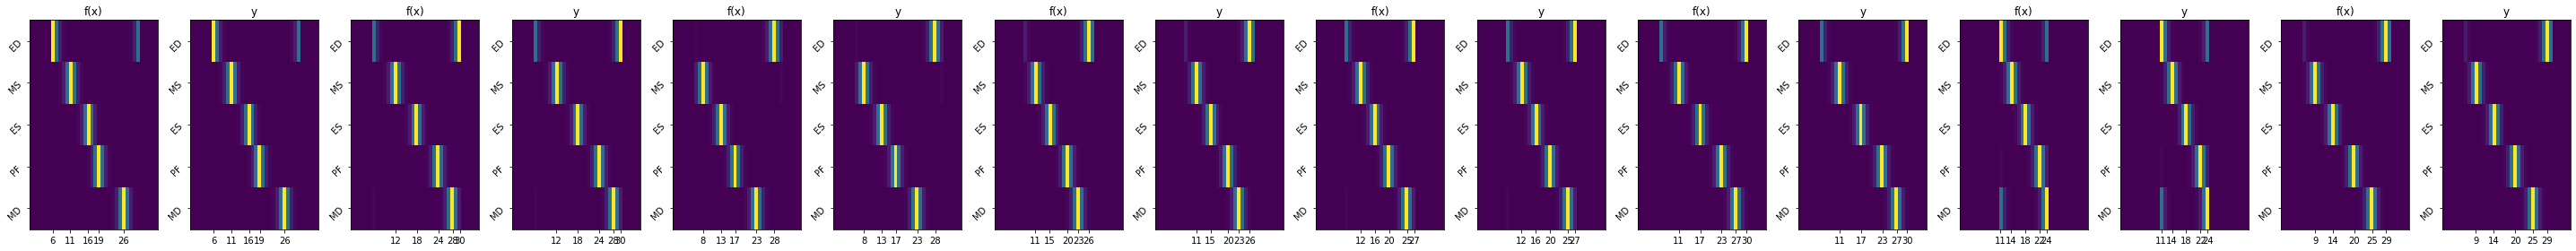

In [13]:
from src.visualization.Visualize import show_phases, show_phases_transpose
_ = show_phases_transpose(outputs,outputs)

In [11]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff, meandiff_transpose
score_fn = meandiff_transpose
score_fn(outputs, outputs).numpy()

gt_idx shape: (8, 5)
pred_idx shape: (8, 5)
filled shape: (8, 5)


0.0

(8, 36, 5)
(5, 36, 8)


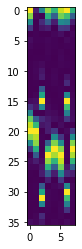

In [13]:
temp = outputs[:,0,...]
print(temp.shape)
print(temp.T.shape)
plt.imshow(temp.T[0])

In [17]:
# calculate the meandiff score for all batches
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

[<tf.Tensor: shape=(), dtype=float32, numpy=6.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.875>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.875>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.75>]

In [18]:
tf.reduce_mean(scores).numpy()

6.75

# Generator tests

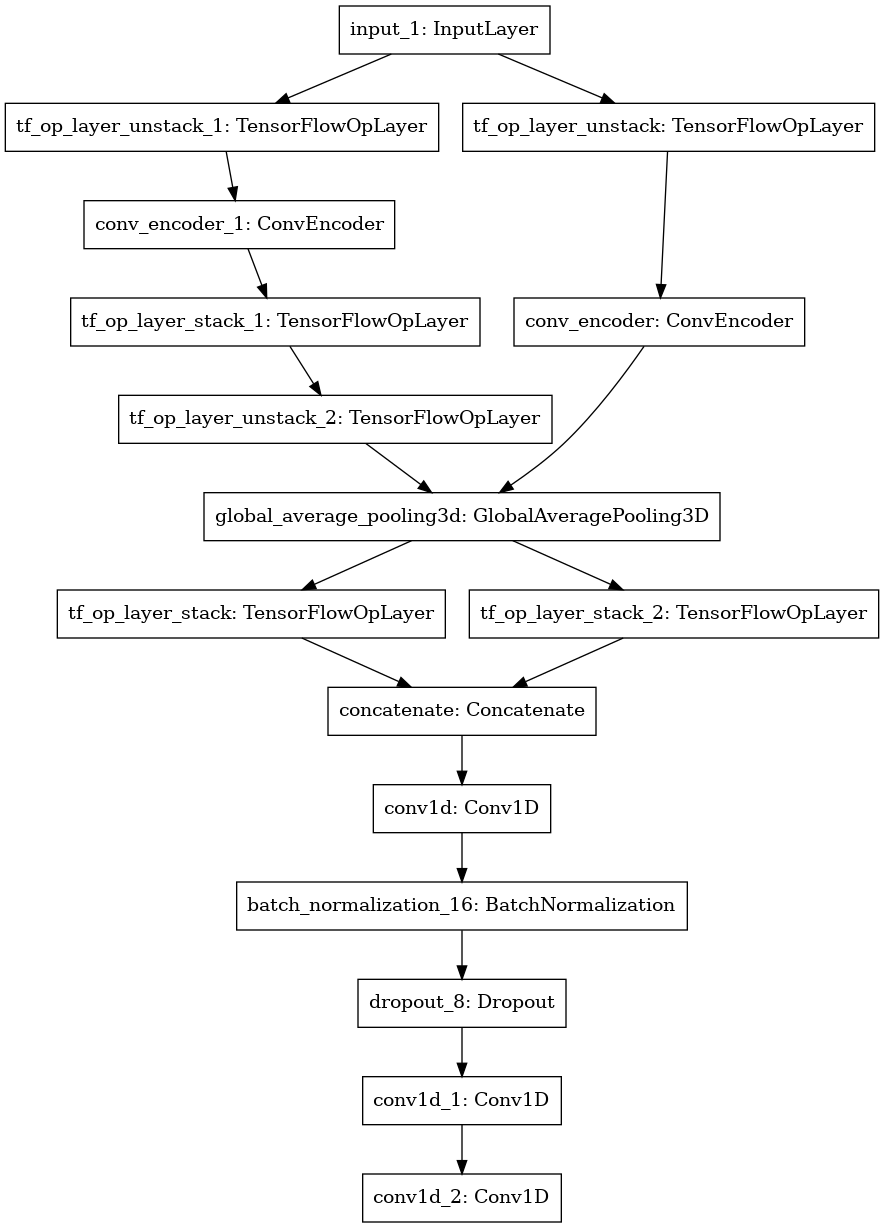

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)